In [1]:
import gym
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm as tqdm, trange
from dataclasses import dataclass
from typing import Tuple, Iterable, List, Dict, Optional
from functools import partial
from abc import ABC, abstractmethod

%matplotlib inline
sns.set_style("whitegrid")
sns.set_palette("colorblind")
plt.rcParams.update({'font.size': 14})

trange = partial(trange, position=0)
tqdm = partial(tqdm, position=0)

# Часть первая
## Пункт 1
>Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.  

Это эпизодическая задача, причём средняя длина эпизода небольшая (единицы ходов), поэтому положим $\gamma = 1.$ По этой причине return ($G_t$) на каждом ходу будет просто равен reward на последнем ходу.  
Самый простой способ оценить средний выигрыш стратегии - сгенерировать большое число эпизодов и усреднить выигрыш. Так и сделаем.  
В модуль contracts вынесены общие интерфейсы для всех стратегий, состояний и окружений

In [2]:
from contracts import State, Strategy, EnvironmentWrapper

@dataclass(frozen=True)
class BaselineState(State):
    """Состояние для подсчёта статистик по baseline стратегии"""
    player_sum: int  # Сумма на руках игрока
    usable_ace: bool  # Есть ли на руках туз, считающийся за 11
    natural_blackjack: bool  # Есть ли на руках ровно 2 карты, дающие в сумме 21


class BaselineStrategy(Strategy):
    def get_action(self, state: BaselineState) -> int:
        if state.player_sum < 19:
            return 1  # hit
        return 0  # stand

In [3]:
def baseline_state_getter(gym_state: Tuple, env: gym.Env) -> BaselineState:
    """Оборачивает состояние из gym.Env в BaselineState"""
    player_sum, dealer_card, usable_ace = gym_state
    natural_blackjack = player_sum == 21 and len(env.player) == 2
    # Для baseline стратегии карта дилера не имеет значения
    # А вот natural_blackjack важен для статистики _начальных_ состояний
    return BaselineState(player_sum, usable_ace, natural_blackjack)

In [4]:
env = EnvironmentWrapper(gym.make('Blackjack-v0', natural=True), baseline_state_getter)

In [5]:
baseline = BaselineStrategy()

In [6]:
def run_episode(env: EnvironmentWrapper, strategy: Strategy) -> Tuple[float, Iterable[State]]:
    """Генерирует эпизод по стратегии, возвращает финальный reward и список состояний"""
    state = env.reset()
    states = []
    while True:
        states.append(state)
        action = strategy.get_action(state)
        state, reward, done =  env.step(action)
        if done:
            return reward, states

def eval_baseline_strategy(env: EnvironmentWrapper, strategy: Strategy, num_iterations: int) -> float:
    """Оценивает средний reward стратегии"""
    return np.mean([run_episode(env, strategy)[0] for _ in trange(num_iterations)])

In [7]:
NUM_ITER = int(2e6)

In [8]:
eval_baseline_strategy(env, baseline, NUM_ITER)

100%|██████████| 2000000/2000000 [01:30<00:00, 22168.23it/s]


-0.179585

Но ничто нам не мешает немного перемудрить и построить Monte-Carlo estimation функции $V_{\pi}(s)$, а затем взять её матожидание по распределению начальных состояний (которое тоже можно оценить методом Монте-Карло).  
Оценим вероятности начальных состояний.  
В модуль table_functions вынесены классы, которые умеют пересчитывать на лету табличные функции. Например, TableDistribution пересчитывает частоты объектов, а RunningMeans обновляет средние арифметические значения по ключам.

In [9]:
from table_functions import TableDistribution, TableFunction, RunningMeans, RunningExp

In [10]:
TableDistribution.__doc__

'Итеративно обновляет вероятности значений value'

In [11]:
TableFunction.__doc__

'Родительский класс для итеративно обновляемых табличных функций'

In [12]:
RunningMeans.__doc__

'Итеративно обновляет средние (арифметические) значения value для каждого key'

In [13]:
RunningExp.__doc__

'Выполняет итеративное экспоненциальное сглаживание значений value для каждого key'

In [14]:
starts_distribution = TableDistribution(env.reset() for _ in trange(NUM_ITER))

100%|██████████| 2000000/2000000 [00:52<00:00, 38160.02it/s]


In [15]:
starts_distribution

TableDistribution(total=2000000, unique=27)
	BaselineState(player_sum=20, usable_ace=False, natural_blackjack=False)	0.095188	n=190376
	BaselineState(player_sum=12, usable_ace=False, natural_blackjack=False)	0.088605	n=177210
	BaselineState(player_sum=13, usable_ace=False, natural_blackjack=False)	0.082975	n=165949
	BaselineState(player_sum=14, usable_ace=False, natural_blackjack=False)	0.077154	n=154308
	BaselineState(player_sum=15, usable_ace=False, natural_blackjack=False)	0.071107	n=142214
	BaselineState(player_sum=16, usable_ace=False, natural_blackjack=False)	0.065292	n=130584
	BaselineState(player_sum=17, usable_ace=False, natural_blackjack=False)	0.059118	n=118236
	BaselineState(player_sum=18, usable_ace=False, natural_blackjack=False)	0.052772	n=105544
	BaselineState(player_sum=19, usable_ace=False, natural_blackjack=False)	0.047459	n=94918
	BaselineState(player_sum=21, usable_ace=True, natural_blackjack=True)	0.047223	n=94445
	BaselineState(player_sum=11, usable_ace=False, na

In [16]:
def estimate_V(env: EnvironmentWrapper, strategy: Strategy, num_iterations: int) -> RunningMeans:
    """Оценивает V-функцию стратегии strategy по num_iterations запускам"""
    V = RunningMeans()
    for _ in trange(num_iterations):
        #  Поскольку gamma==1, можно брать reward с последнего шага в качестве return на всех шагах,
        #  а также обходить эпизод от начала к концу, а не наоборот
        reward, states = run_episode(env, strategy)
        for state in states:
            V.update(state, reward)
    return V

In [17]:
baseline_V = estimate_V(env, baseline, NUM_ITER)

100%|██████████| 2000000/2000000 [01:48<00:00, 18357.29it/s]


In [18]:
baseline_V

RunningMeans(total=3489928, unique=29
	BaselineState(player_sum=21, usable_ace=True, natural_blackjack=True)	1.321791	n=94507)
	BaselineState(player_sum=21, usable_ace=False, natural_blackjack=False)	0.880040	n=172582)
	BaselineState(player_sum=21, usable_ace=True, natural_blackjack=False)	0.879290	n=22815)
	BaselineState(player_sum=20, usable_ace=True, natural_blackjack=False)	0.581711	n=45722)
	BaselineState(player_sum=20, usable_ace=False, natural_blackjack=False)	0.579293	n=366799)
	BaselineState(player_sum=19, usable_ace=False, natural_blackjack=False)	0.267818	n=273137)
	BaselineState(player_sum=19, usable_ace=True, natural_blackjack=False)	0.261752	n=44225)
	BaselineState(player_sum=11, usable_ace=False, natural_blackjack=False)	0.043317	n=115520)
	BaselineState(player_sum=10, usable_ace=False, natural_blackjack=False)	-0.023536	n=97042)
	BaselineState(player_sum=12, usable_ace=True, natural_blackjack=False)	-0.100815	n=11784)
	BaselineState(player_sum=13, usable_ace=True, natur

Для Natural blackjack оценка не равна 1.5, потому что дилер тоже может набрать 21, и будет ничья

In [19]:
def expectation(func: TableFunction, distribution: TableDistribution) -> float:
    """Считает матожидание табличной функции по табличному распределению"""
    keys = set(func.keys()) & set(distribution.keys())
    return sum([func[key] * distribution[key] for key in keys])

In [20]:
expectation(baseline_V, starts_distribution)

-0.17986301853757497

Оценки получились довольно близкие

## Пункты 2 и 3
>Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym  

>Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.

### Пояснения к коду
Далее по-прежнему используются различные реализации `State` и `state_getter` под каждый вариант задачи.  
В роли обучаемой Q-функции выступают реализации `TableFunction`, использующие в качестве ключей пары (состояние, действие). Все они умеют пересчитывать текущее значение на основе нового (метод `update`):  
- `RunningMeans` просто пересчитывает среднее арифметическое, учитывая новое значение, текущее среднее и число элементов  
- `RunningExp` выполняет экспоненциальное сглаживание, вычисляя выпуклую комбинацию текущего значения и нового с весами $1-\alpha$ и $\alpha$ соответственно  

В связи с тем, что в третьей части пространство пар (состояние, действие) получается довольно большим и обучение занимает много времени, я решил написать параллельный вариант обучения и валидации. С валидацией всё понятно - параллельно генерируем множество эпизодов в каждом процессе, вычисляем средний реворд, а затем в главном процессе вычисляем общее среднее и стандартное отклонение средних. С обучением сложнее. Оно организовано по _эпохам_. На каждой эпохе берётся текущая Q-функция (либо обученная на прошлых эпохах, либо инициализированная нулями), а затем в каждом процессе независимо происходит дообучение Q-функции по случайным эпизодам. В конце эпохи результаты объединяются. Это реализовано в методах `TableFunction.merge`. В случае с `RunningMeans` пересчёт организован так, чтобы имитировать последовательное обновление одной функции. Для `RunningExp` реализовано 5 стратегий усреднения, но все они дают одинаковые в плане итогового качества результаты.  
Понятно, что параллельные версии алгоритмов не вполне эквивалентны последовательному обучению, однако кажется, что кроме ускорения работы достигается лучший exploration.

### On-policy Monte Carlo control
Реализуем on-policy Monte Carlo control для $\varepsilon-$ мягкой стратегии

In [21]:
@dataclass(frozen=True)
class FullState(State):
    player_sum: int   # Сумма на руках игрока
    dealer_card: int  # Карта дилера, лежащая в открытую
    usable_ace: bool  # Есть ли на руках туз, считающийся за 11

In [22]:
class EpsilonGreedyStrategy(Strategy):
    def __init__(self, actions: List[int], epsilon: float):
        self.actions = actions
        self.epsilon = epsilon
        #  Заранее посчитаем массив базовых вероятностей выбрать неоптимальное действие,
        #  для оптимального действия будем прибавлять 1 - epsilon.
        #  Массив создаётся заранее для ускорения работы
        self.weights = np.zeros_like(actions) + epsilon / len(actions)
    
    def _get_best_action_idx(self, state: State, Q: TableFunction) -> int:
        """Возвращает индекс действия, максимизирующего Q(state, a)"""
        action_values = [Q[(state, action)] for action in self.actions]
        return np.argmax(action_values)
    
    def get_action(self, state: FullState, Q: TableFunction) -> int:
        best_action_idx = self._get_best_action_idx(state, Q)
        if self.epsilon == 0:
            #  Чисто жадная стратегия
            return self.actions[best_action_idx]
        self.weights[best_action_idx] += 1 - self.epsilon
        action = np.random.choice(self.actions, p=self.weights)
        # возвращаем обратно базовую вероятность
        self.weights[best_action_idx] = self.epsilon / len(self.actions)
        return action
    
    def __repr__(self):
        if self.epsilon == 0:
            return 'GreedyStrategy'
        else:
            return f'EpsilonGreedyStrategy(epsilon={round(self.epsilon, 3)})'

In [23]:
def full_state_getter(gym_state: Tuple, env: gym.Env) -> FullState:
    """Оборачивает состояние из gym.Env в FullState"""
    player_sum, dealer_card, usable_ace = gym_state
    return FullState(player_sum, dealer_card, usable_ace)

In [24]:
def run_episode_for_Q(env: EnvironmentWrapper,
                      strategy: Strategy,
                      Q: TableFunction) -> Tuple[float, List[Tuple[State, int]]]:
    """Генерирует эпизод по стратегии, возвращает финальный reward
    и список  пар (состояние, действие)"""
    state = env.reset()
    state_actions = []
    while True:
        action = strategy.get_action(state, Q)
        state_actions.append((state, action))
        state, reward, done = env.step(action)
        if done:
            return reward, state_actions

In [25]:
def evaluate_strategy(env: EnvironmentWrapper,
                      strategy: Strategy,
                      Q: TableFunction,
                      num_iterations: int) -> float:
    """Генерирует num_iterations запусков по стратегии (strategy, Q)
    и возвращает средний reward"""
    env.env.seed()  # Устанавливаем случайный random_seed. Важно для параллельной обработки
    returns = [run_episode_for_Q(env, strategy, Q)[0] for _ in trange(num_iterations)]
    return np.mean(returns)

In [26]:
from joblib.externals.loky import set_loky_pickler

# set_loky_pickler('pickle')  # Работает быстрее, но не поддерживает объекты, созданные в __main__, в т.ч. в ноутбуке

PARALLEL_BACKEND = 'loky'
# PARALLEL_BACKEND = 'multiprocessing'  # Работает быстрее, но не поддерживает вложенный параллелизм, а также
# пишет вывод со всех потоков

In [27]:
from joblib import Parallel, delayed, parallel_backend

def evaluate_strategy_parallel(env: EnvironmentWrapper,
                                strategy: Strategy,
                                Q: TableFunction,
                                num_iterations: int,
                                n_jobs: int,
                                n_times: Optional[int] = None) -> Tuple[float, float]:
    """Оценивает средний выигрыш стратегии (strategy, Q) за num_iterations n_times раз
    и возвращает средний reward и его стандартное отклонение.
    Каждая оценка осуществляется в отдельном процессе (всего n_jobs процессов).
    По умолчанию n_times = n_jobs"""
    assert isinstance(n_jobs, int) and n_jobs > 0
    n_times = n_times or n_jobs
    with parallel_backend(PARALLEL_BACKEND, n_jobs=n_jobs):
        returns = Parallel()(delayed(evaluate_strategy)(env, strategy, Q, num_iterations)
                             for _ in range(n_times))
    return float(np.mean(returns)), float(np.std(returns))

In [28]:
class Trainer(ABC):
    """Родительский класс для алгоритмов обучения Q-функции"""

    @abstractmethod
    def __init__(self, env: EnvironmentWrapper):
        self.env = env
        self.actions = list(range(env.env.action_space.n))

    @abstractmethod
    def fit(self, num_iterations: int) -> TableFunction:
        """Генерирует num_iterations эпизодов
        и обновляет в процессе Q-функцию по заданному алгоритму"""
        pass
    
    def fit_parallel(self, num_iterations: int, n_jobs: int) -> TableFunction:
        """В каждом из n_jobs процессов независимо обучает Q-функцию
        int(num_iterations / n_jobs) итераций, начиная с текущих значений.
        Затем объединяет полученные результаты, используя конкретную реализацию
        TableFunction.merge. Например, RunningMeans корректно пересчитывает средние арифметические,
        как если бы update последовательно вызывался у текущей функции Q.
        RunningExp поддерживает 5 стратегий усреднения, но на итоговое качество их выбор практически не влияет.
        Подробнее можно посмотреть в table_functions.py и в tests/test_table_functions.py"""
        assert isinstance(n_jobs, int) and n_jobs > 0
        worker_iterations = int(num_iterations / n_jobs)
        with parallel_backend(PARALLEL_BACKEND, n_jobs=n_jobs):
            Qs = Parallel()(delayed(self.fit)(worker_iterations) for _ in range(n_jobs))
        self.Q.merge(Qs)
        return self.Q

Собственно весь алгоритм on-policy Monte Carlo control находится в следующей ячейке.  
Объект RunningMeans просто пересчитывает среднее значение по ключу (state, action), учитывая новый reward

In [29]:
class MccTrainer(Trainer):
    """Реализует on-policy Monte Carlo control """

    def __init__(self,
                 env: EnvironmentWrapper,
                 epsilon: float):
        super().__init__(env)
        self.epsilon = epsilon
        self.strategy = EpsilonGreedyStrategy(self.actions, epsilon=epsilon)
        self.Q = RunningMeans()

    def fit(self, num_iterations: int) -> RunningMeans:
        self.env.env.seed()  # Устанавливаем случайный random_seed. Важно для параллельной обработки
        Q = self.Q
        for _ in trange(num_iterations):
            reward, state_actions = run_episode_for_Q(self.env, self.strategy, Q)
            for state, action in state_actions:
                Q.update((state, action), reward)
        return Q

    def __repr__(self) -> str:
        return f'MccTrainer(epsilon={self.epsilon})'

#### Подбор гиперпараметров
Подберём оптимальное значение $\varepsilon$ с помощью байесовской оптимизации на основе гауссовских процессов. Оптимизатор возьмём из пакета scikit-optimize.  
Обучать будем $\varepsilon-$жадную стратегию, но оценивать будем качество жадной стратегии, играющей по обученной Q

In [30]:
class HyperparametersEstimator(ABC):
    """Родительский класс для оценки гиперпараметров алгоритмов обучения.
    Метод __call__ принимает на вход значения гиперпараметров и возвращает
    -1*(средний реворд обученной стратегии), т.к. эту функцию мы будем минимизировать.
    Оценивается качество работы _жадной_ стратегии, играющей по Q, обученной
    алгоритмом с заданными гиперпараметрами"""

    def __init__(self,
                    env: EnvironmentWrapper,
                    train_iterations: int,
                    eval_iterations: int,
                    train_epochs: int,
                    n_jobs: int):
        assert isinstance(n_jobs, int) and n_jobs > 0
        self.env = env
        self.train_iterations = train_iterations
        self.eval_iterations = eval_iterations
        self.train_epochs = train_epochs
        self.n_jobs = n_jobs

    def _get_negative_score(self, trainer: Trainer):
        eval_strategy = EpsilonGreedyStrategy(trainer.actions, epsilon=0)
        if self.n_jobs != 1:
            for _ in range(self.train_epochs):
                Q = trainer.fit_parallel(self.train_iterations, self.n_jobs)
            score = evaluate_strategy_parallel(self.env, eval_strategy, Q, self.eval_iterations, self.n_jobs)[0]
        else:
            for _ in range(self.train_epochs):
                Q = trainer.fit(self.train_iterations)
            score = evaluate_strategy(self.env, eval_strategy, Q, self.eval_iterations)
        return -score

    @abstractmethod
    def __call__(self, *args) -> float:
        pass

In [31]:
class MccHyperparametersEstimator(HyperparametersEstimator):
    """Оценивает набор гиперпараметров для алгоритма on-policy Monte Carlo control.
    Возвращает -1*(средний реворд обученной стратегии), т.к. эту функцию мы будем минимизировать.
    Оценивается качество работы _жадной_ стратегии, играющей по обученной Q"""

    def __call__(self, epsilon: float) -> float:
        trainer = MccTrainer(self.env, epsilon)
        return self._get_negative_score(trainer)

In [32]:
from skopt import Optimizer
from scipy.optimize.optimize import OptimizeResult
from skopt.space import Real, Space
import warnings
warnings.filterwarnings('ignore', message='The objective has been evaluated at this point before.')

In [33]:
def get_optimal_parameters(estimator: HyperparametersEstimator,
                            parameters_space: List[Space],                          
                            n_jobs: int,
                            iterations: int) -> Tuple[OptimizeResult, Dict[str, float]]:
    print(f'Searching for optimal values of:')
    for param in parameters_space:
        print(f'\t"{param.name}" in space {param}', flush=True)
    optimizer = Optimizer(dimensions=parameters_space, base_estimator='gp')
    with parallel_backend(PARALLEL_BACKEND, n_jobs=n_jobs):
        for i in trange(iterations, desc='OptIter'):
            params_sample = optimizer.ask(n_points=n_jobs)
            tasks = (delayed(estimator)(*param) for param in params_sample)
            scores = Parallel()(tasks)
            optimizer.tell(params_sample, scores)
    result = optimizer.get_result()
    optimal_params = {s.name: val for s, val in zip(parameters_space, result.x)}
    return result, optimal_params

In [34]:
from skopt.plots import plot_objective, plot_convergence, plot_evaluations

def show_results(results: OptimizeResult, optimal_params: Dict[str, float]):
    print(f'Best mean reward: {-results.fun:.6f}')
    print('Optimal parameters:')
    formatted_params = []
    for param, value in optimal_params.items():
        try:
            formatted_params.append(f'\t{param}\t= {value:.6f}')
        except:
            formatted_params.append(f'\t{param}\t= {value}')
    print('\n'.join(formatted_params))
    plot_convergence(results)
    plot_evaluations(results, dimensions=[param for param in optimal_params.keys()]);
    plot_objective(results, size=4)
    #  plt.tight_layout()

In [35]:
def describe_opt_params():
    print('Параметры процедуры подбора гиперпараметров')
    print(f'Общее число оцениваемых точек: {OPT_ITERATIONS * NUM_PARALLEL_POINTS}')
    print(f'Число итераций процедуры байесовской оптимизации: {OPT_ITERATIONS}')
    print(f'Число параллельно оцениваемых точек на одной итерации: {NUM_PARALLEL_POINTS}')
    print(f'Число процессов для обучения одного алгоритма: {NUM_ESTIMATE_PROCESS}')
    print(f'Число эпох обучения: {OPT_TRAIN_EPOCHS}')
    print(f'Число итераций обучения на одной эпохе в одном процессе: {OPT_TRAIN_EPOCH_ITER / NUM_ESTIMATE_PROCESS:.2e}')
    print(f'Общее число итераций обучения на одной эпохе: {OPT_TRAIN_EPOCH_ITER:.2e}')
    print(f'Общее число итераций обучения: {OPT_TRAIN_EPOCHS * OPT_TRAIN_EPOCH_ITER:.2e}')
    print(f'Число параллельных запусков валидации: {NUM_ESTIMATE_PROCESS}')
    print(f'Число итераций валидации на одном запуске: {OPT_EVAL_ITER:.2e}')
    iter_equivalent = OPT_ITERATIONS * (OPT_TRAIN_EPOCH_ITER / NUM_ESTIMATE_PROCESS * OPT_TRAIN_EPOCHS + OPT_EVAL_ITER)
    print(f'Однопоточный эквивалент общего числа итераций: {iter_equivalent:.2e}')
    print(f'Общее число задействованных процессов: {NUM_PARALLEL_POINTS * NUM_ESTIMATE_PROCESS}')

In [36]:
OPT_ITERATIONS = 6
NUM_PARALLEL_POINTS = 4
NUM_ESTIMATE_PROCESS = 10
OPT_TRAIN_EPOCHS = 10
OPT_TRAIN_EPOCH_ITER = int(1e6)
OPT_EVAL_ITER = int(1e6)

In [37]:
describe_opt_params()

Параметры процедуры подбора гиперпараметров
Общее число оцениваемых точек: 24
Число итераций процедуры байесовской оптимизации: 6
Число параллельно оцениваемых точек на одной итерации: 4
Число процессов для обучения одного алгоритма: 10
Число эпох обучения: 10
Число итераций обучения на одной эпохе в одном процессе: 1.00e+05
Общее число итераций обучения на одной эпохе: 1.00e+06
Общее число итераций обучения: 1.00e+07
Число параллельных запусков валидации: 10
Число итераций валидации на одном запуске: 1.00e+06
Однопоточный эквивалент общего числа итераций: 1.20e+07
Общее число задействованных процессов: 40


In [38]:
epsilon_space = Real(0.01, 1, prior='log-uniform', name='epsilon')
mcc_space = [epsilon_space]

In [39]:
env = EnvironmentWrapper(gym.make('Blackjack-v0', natural=True), full_state_getter)

In [40]:
mcc_estimator = MccHyperparametersEstimator(env, OPT_TRAIN_EPOCH_ITER, OPT_EVAL_ITER, OPT_TRAIN_EPOCHS, NUM_ESTIMATE_PROCESS)

In [41]:
mcc_result, optimal_mcc_params = get_optimal_parameters(mcc_estimator, mcc_space, NUM_PARALLEL_POINTS, OPT_ITERATIONS)

Searching for optimal values of:
	"epsilon" in space Real(low=0.01, high=1, prior='log-uniform', transform='identity')


OptIter: 100%|██████████| 6/6 [55:30<00:00, 555.10s/it]


In [42]:
best_mcc_epsilon = optimal_mcc_params['epsilon']

Best mean reward: -0.025547
Optimal parameters:
	epsilon	= 0.033900


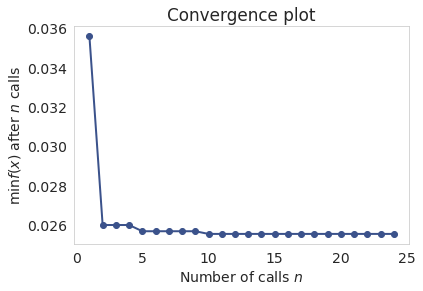

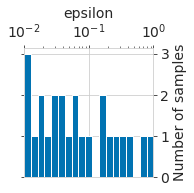

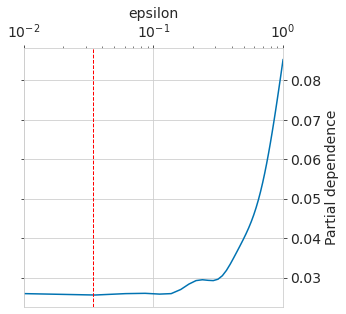

In [43]:
# Примечание: на графиках значения среднего реворда указаны со знаком минус
show_results(mcc_result, optimal_mcc_params)

#### Обучение стратегии алгоритмом on-policy Monte Carlo control
Обучим Q-функцию, используя оптимальные гиперпараметры.  
В процессе несколько раз оценим средний реворд, играя по жадной стратегии. Также оценим дисперсию среднего, запуская несколько оценок для одной и той же Q-функции

In [44]:
def train_and_eval(trainer: Trainer,
                    train_iterations: int,
                    eval_iterations: int,
                    num_checkpoints: int,
                    n_jobs: int) -> Tuple[TableFunction, List[float], List[float]]:
    """Обучает Q-функцию с помощью trainer, оценивая в процессе жадную стратегию,
    играющую по обученной Q. На каждом чекпоинте прогоняем n_jobs раз
    eval_iterations запусков, сохраняя их среднее и стандартное отклонение"""
    #  Обучать будем по эпохам, оценивая качество после каждой из них
    epoch_iterations = int(train_iterations / num_checkpoints)
    eval_returns_mean, eval_returns_std = [], []
    eval_strategy = EpsilonGreedyStrategy(trainer.actions, epsilon=0)
    print(f'Trainer: {trainer}')
    print(f'Training {trainer.strategy}, evaluating {eval_strategy}', flush=True)
    eval_string = f'{eval_strategy} mean return over {eval_iterations} eval iterations ({n_jobs} times):'
    for epoch in trange(num_checkpoints, desc='Epoch'):
        print(f'Epoch {epoch+1} of {num_checkpoints} ({epoch_iterations} runs)', flush=True)
        trainer.fit_parallel(epoch_iterations, n_jobs)
        eval_mean, eval_std = evaluate_strategy_parallel(trainer.env, eval_strategy, trainer.Q, eval_iterations, n_jobs)
        eval_returns_mean.append(eval_mean)
        eval_returns_std.append(eval_std)
        print(f'{eval_string} {eval_mean:.6f} +/- {eval_std:.6f}', flush=True)
    return trainer.Q, eval_returns_mean, eval_returns_std

In [45]:
def plot_returns(means: List[float],
                 stds: List[float],
                 train_iterations: int,
                 eval_iterations: int,
                 num_checkpoints: int,
                 eval_n_times: int):
    """Отрисовывает средние реворды и их стандартные отклонения"""
    x_values = np.linspace(train_iterations/num_checkpoints, train_iterations, num_checkpoints)
    means = np.array(means)
    stds = np.array(stds)
    plt.figure(figsize=(15, 7))
    plt.plot(x_values, means, 'or')
    plt.plot(x_values, means, '-', color='gray')
    plt.fill_between(x_values, means - stds, means + stds,
                     color='gray', alpha=0.2)    
    plt.title(f'Статистика выигрышей стратегии по {eval_n_times} оценкам ({eval_iterations} запусков каждая)',
              fontsize=16)
    plt.xlabel('Число итераций обучения', fontsize=16)
    plt.ylabel('Выигрыш стратегии', fontsize=16)
    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)

In [46]:
def describe_train_params():
    print('Параметры процедуры обчения Q-функции')
    print(f'Число эпох: {NUM_CHECKPOINTS}')
    print(f'Число процессов для обучения алгоритма: {N_JOBS}')
    print(f'Число процессов для оценки алгоритма: {N_JOBS}')
    print(f'Общее число итераций обучения: {TRAIN_ITER:.2e}')
    epoch_iters = TRAIN_ITER / NUM_CHECKPOINTS
    print(f'Общее число итераций обучения на одной эпохе: {epoch_iters:.2e}')
    print(f'Число итераций обучения на одной эпохе в одном процессе: {epoch_iters / N_JOBS:.2e}')
    print(f'Число итераций валидации на одном запуске: {EVAL_ITER:.2e}')
    iter_equivalent = (epoch_iters / N_JOBS + EVAL_ITER) * NUM_CHECKPOINTS
    print(f'Однопоточный эквивалент общего числа итераций: {iter_equivalent:.2e}')
    print(f'Общее число задействованных процессов: {N_JOBS}')

In [47]:
TRAIN_ITER = int(1e7)
EVAL_ITER = int(1e6)
N_JOBS = 40
NUM_CHECKPOINTS = 10

In [48]:
describe_train_params()

Параметры процедуры обчения Q-функции
Число эпох: 10
Число процессов для обучения алгоритма: 40
Число процессов для оценки алгоритма: 40
Общее число итераций обучения: 1.00e+07
Общее число итераций обучения на одной эпохе: 1.00e+06
Число итераций обучения на одной эпохе в одном процессе: 2.50e+04
Число итераций валидации на одном запуске: 1.00e+06
Однопоточный эквивалент общего числа итераций: 1.02e+07
Общее число задействованных процессов: 40


In [49]:
mcc_trainer = MccTrainer(env, best_mcc_epsilon)

In [50]:
mcc_Q, mcc_mean, mcc_std = train_and_eval(mcc_trainer, TRAIN_ITER, EVAL_ITER, NUM_CHECKPOINTS, N_JOBS)

Trainer: MccTrainer(epsilon=0.033899759379337126)
Training EpsilonGreedyStrategy(epsilon=0.034), evaluating GreedyStrategy


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026947 +/- 0.001077


Epoch:  10%|█         | 1/10 [03:22<30:20, 202.24s/it]

Epoch 2 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026945 +/- 0.001004


Epoch:  20%|██        | 2/10 [06:44<26:58, 202.30s/it]

Epoch 3 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026703 +/- 0.000976


Epoch:  30%|███       | 3/10 [10:07<23:37, 202.50s/it]

Epoch 4 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026827 +/- 0.000983


Epoch:  40%|████      | 4/10 [13:31<20:17, 202.89s/it]

Epoch 5 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026512 +/- 0.000974


Epoch:  50%|█████     | 5/10 [16:54<16:55, 203.02s/it]

Epoch 6 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026630 +/- 0.000796


Epoch:  60%|██████    | 6/10 [20:16<13:30, 202.62s/it]

Epoch 7 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026704 +/- 0.000931


Epoch:  70%|███████   | 7/10 [23:40<10:09, 203.11s/it]

Epoch 8 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026508 +/- 0.000856


Epoch:  80%|████████  | 8/10 [27:02<06:45, 202.86s/it]

Epoch 9 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026577 +/- 0.000926


Epoch:  90%|█████████ | 9/10 [30:25<03:22, 202.72s/it]

Epoch 10 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026747 +/- 0.001165


Epoch: 100%|██████████| 10/10 [33:49<00:00, 202.93s/it]


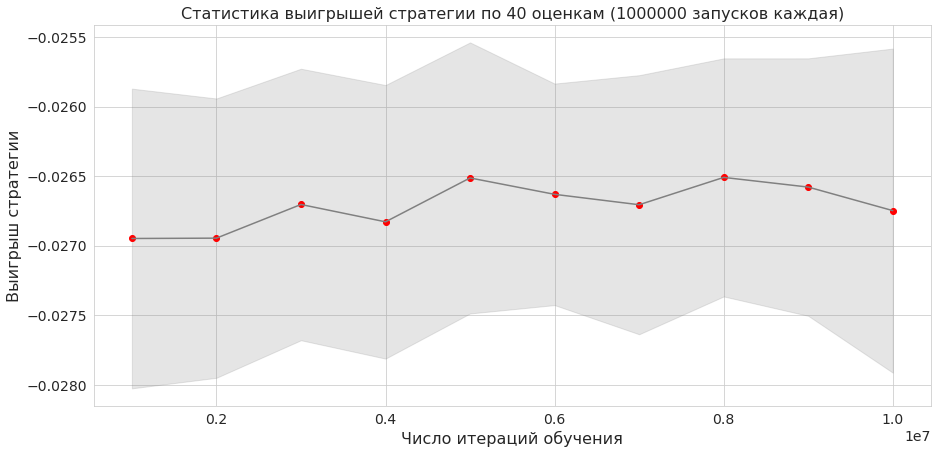

In [51]:
plot_returns(mcc_mean, mcc_std, TRAIN_ITER, EVAL_ITER, NUM_CHECKPOINTS, N_JOBS)

In [52]:
print(mcc_Q.show(20))

RunningMeans(total=14887114, unique=560 [top 20]
	(FullState(player_sum=21, dealer_card=9, usable_ace=True), 0)	1.322833	n=43902)
	(FullState(player_sum=21, dealer_card=8, usable_ace=True), 0)	1.321211	n=42841)
	(FullState(player_sum=21, dealer_card=7, usable_ace=True), 0)	1.311388	n=43213)
	(FullState(player_sum=21, dealer_card=6, usable_ace=True), 0)	1.281404	n=42821)
	(FullState(player_sum=21, dealer_card=5, usable_ace=True), 0)	1.263277	n=42742)
	(FullState(player_sum=21, dealer_card=4, usable_ace=True), 0)	1.260293	n=42700)
	(FullState(player_sum=21, dealer_card=2, usable_ace=True), 0)	1.253626	n=42675)
	(FullState(player_sum=21, dealer_card=3, usable_ace=True), 0)	1.252743	n=42468)
	(FullState(player_sum=21, dealer_card=10, usable_ace=True), 0)	1.250516	n=175382)
	(FullState(player_sum=21, dealer_card=9, usable_ace=False), 0)	0.938780	n=46766)
	(FullState(player_sum=21, dealer_card=8, usable_ace=False), 0)	0.930141	n=45878)
	(FullState(player_sum=21, dealer_card=7, usable_ace=Fal

Существенно лучше бейзлайна!

### Q-learning
А что, если попробовать TD-обучение? Реализуем Q-learning.  
У нас практически всё для этого готово: нужно только заменить способ пересчёта значения Q-функции.  
Вместо RunningMeans будем использовать RunningExp, реализующий экспоненциальное сглаживание вместо среднего арифметического.

In [53]:
class QlearningTrainer(Trainer):
    """Реализует алгоритм Q-learning """

    def __init__(self,
                 env: EnvironmentWrapper,
                 epsilon: float,
                 alpha: float):
        super().__init__(env)
        self.epsilon = epsilon
        self.alpha = alpha
        self.strategy = EpsilonGreedyStrategy(self.actions, epsilon=epsilon)
        self.Q = RunningExp(alpha)

    def _get_best_action(self, state: State) -> int:
        """Возвращает действие, максимизирующего Q(state, a)"""
        action_values = [self.Q[(state, action)] for action in self.actions]
        return self.actions[np.argmax(action_values)]

    def fit(self, num_iterations: int) -> RunningExp:
        self.env.env.seed()  # Устанавливаем случайный random_seed. Важно для параллельной обработки
        Q = self.Q
        for _ in trange(num_iterations):
            reward, state_actions = run_episode_for_Q(self.env, self.strategy, self.Q)
            #  Поскольку задача эпизодическая, можем обновлять с конца
            #  Также учитываем, что ненулевой реворд есть только для последнего состояния,
            #  gamma==1,
            #  RunningExp автоматически учитывает веса alpha и 1-alpha
            reversed_state_actions = list(reversed(state_actions))
            last_state, last_action = reversed_state_actions[0]
            Q.update((last_state, last_action), reward)
            next_state = last_state
            for state, action in reversed_state_actions[1:]:
                best_next_action = self._get_best_action(next_state)
                update = Q[(next_state, best_next_action)]
                Q.update((state, action), update)
                next_state = state
        return Q

    def __repr__(self) -> str:
        return f'QlearningTrainer(epsilon={self.epsilon}, alpha={self.alpha})'

In [54]:
class QlearningHyperparametersEstimator(HyperparametersEstimator):
    """Оценивает набор гиперпараметров для алгоритма Q-learning.
    Возвращает -1*(средний реворд обученной стратегии), т.к. эту функцию мы будем минимизировать.
    Оценивается качество работы _жадной_ стратегии, играющей по обученной Q"""

    def __call__(self, epsilon: float, alpha: float) -> float:
        trainer = QlearningTrainer(self.env, epsilon, alpha)
        return self._get_negative_score(trainer)

#### Подбор гиперпараметров
Подберём оптимальные значения $\varepsilon$ и $\alpha$

In [55]:
epsilon_space = Real(0.01, 1, prior='log-uniform', name='epsilon')
alpha_space = Real(5e-4, 0.5, prior='log-uniform', name='alpha')
qlearning_space = [epsilon_space, alpha_space]

In [56]:
qlearning_estimator = QlearningHyperparametersEstimator(env, OPT_TRAIN_EPOCH_ITER, OPT_EVAL_ITER,
                                                        OPT_TRAIN_EPOCHS, NUM_ESTIMATE_PROCESS)

In [57]:
qlearning_result, optimal_qlearning_params = get_optimal_parameters(qlearning_estimator,
                                                                    qlearning_space,
                                                                    NUM_PARALLEL_POINTS,
                                                                    OPT_ITERATIONS)

Searching for optimal values of:
	"epsilon" in space Real(low=0.01, high=1, prior='log-uniform', transform='identity')
	"alpha" in space Real(low=0.0005, high=0.5, prior='log-uniform', transform='identity')


OptIter: 100%|██████████| 6/6 [59:13<00:00, 592.24s/it]


In [58]:
best_qlearning_epsilon = optimal_qlearning_params['epsilon']
best_qlearning_alpha = optimal_qlearning_params['alpha']

Best mean reward: -0.025746
Optimal parameters:
	epsilon	= 0.715836
	alpha	= 0.010011


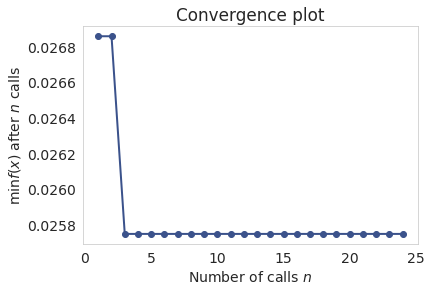

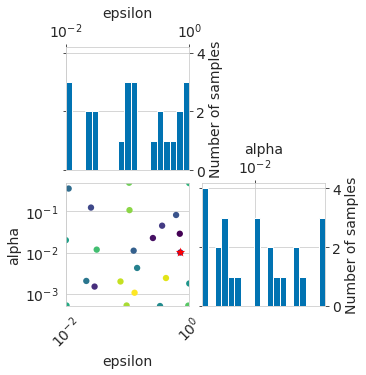

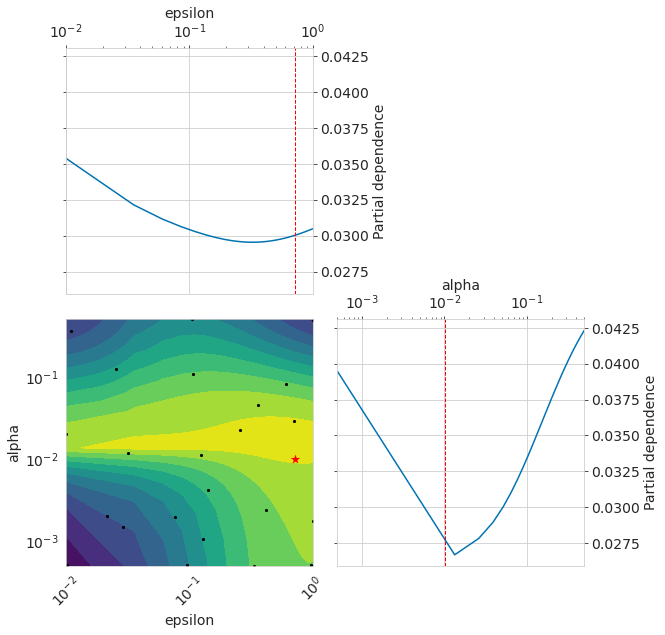

In [59]:
# Примечание: на графиках значения среднего реворда указаны со знаком минус
show_results(qlearning_result, optimal_qlearning_params)

#### Обучение стратегии алгоритмом Q-learning

In [60]:
qlearning_trainer = QlearningTrainer(env, best_qlearning_epsilon, best_qlearning_alpha)

In [61]:
qlearning_Q, qlearning_mean, qlearning_std = train_and_eval(qlearning_trainer,
                                                            TRAIN_ITER,
                                                            EVAL_ITER,
                                                            NUM_CHECKPOINTS,
                                                            N_JOBS)

Trainer: QlearningTrainer(epsilon=0.7158361173640535, alpha=0.01001096743429154)
Training EpsilonGreedyStrategy(epsilon=0.716), evaluating GreedyStrategy


Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.030898 +/- 0.000906


Epoch:  10%|█         | 1/10 [03:27<31:07, 207.51s/it]

Epoch 2 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.027080 +/- 0.000899


Epoch:  20%|██        | 2/10 [06:57<27:45, 208.20s/it]

Epoch 3 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.027036 +/- 0.001025


Epoch:  30%|███       | 3/10 [10:21<24:08, 206.86s/it]

Epoch 4 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026484 +/- 0.000985


Epoch:  40%|████      | 4/10 [13:48<20:42, 207.00s/it]

Epoch 5 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026226 +/- 0.000858


Epoch:  50%|█████     | 5/10 [17:14<17:14, 206.86s/it]

Epoch 6 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026346 +/- 0.001036


Epoch:  60%|██████    | 6/10 [20:37<13:42, 205.61s/it]

Epoch 7 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026683 +/- 0.000955


Epoch:  70%|███████   | 7/10 [24:04<10:18, 206.11s/it]

Epoch 8 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.025840 +/- 0.000996


Epoch:  80%|████████  | 8/10 [27:30<06:52, 206.05s/it]

Epoch 9 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.025806 +/- 0.000964


Epoch:  90%|█████████ | 9/10 [30:55<03:25, 205.60s/it]

Epoch 10 of 10 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026019 +/- 0.001082


Epoch: 100%|██████████| 10/10 [34:21<00:00, 206.16s/it]


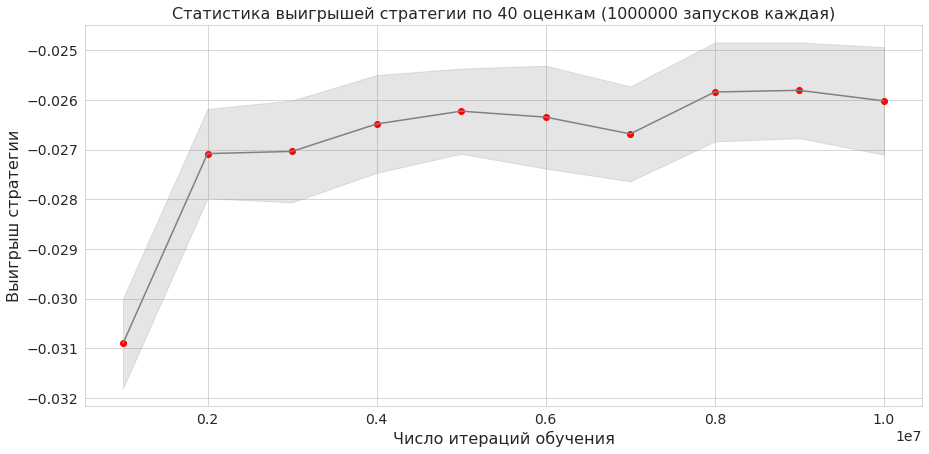

In [62]:
plot_returns(qlearning_mean, qlearning_std, TRAIN_ITER, EVAL_ITER, NUM_CHECKPOINTS, N_JOBS)

In [63]:
print(qlearning_Q.show(20))

RunningExp(alpha=0.01001096743429154, total=14209321, unique=560 [top 20]
	(FullState(player_sum=21, dealer_card=9, usable_ace=True), 0)	1.352269	n=27403)
	(FullState(player_sum=21, dealer_card=8, usable_ace=True), 0)	1.331212	n=27496)
	(FullState(player_sum=21, dealer_card=7, usable_ace=True), 0)	1.325038	n=27028)
	(FullState(player_sum=21, dealer_card=6, usable_ace=True), 0)	1.294819	n=27335)
	(FullState(player_sum=21, dealer_card=5, usable_ace=True), 0)	1.277030	n=26953)
	(FullState(player_sum=21, dealer_card=4, usable_ace=True), 0)	1.272829	n=26760)
	(FullState(player_sum=21, dealer_card=10, usable_ace=True), 0)	1.268243	n=108604)
	(FullState(player_sum=21, dealer_card=2, usable_ace=True), 0)	1.265352	n=26934)
	(FullState(player_sum=21, dealer_card=3, usable_ace=True), 0)	1.256804	n=27015)
	(FullState(player_sum=21, dealer_card=9, usable_ace=False), 0)	0.941925	n=26907)
	(FullState(player_sum=21, dealer_card=8, usable_ace=False), 0)	0.933212	n=26811)
	(FullState(player_sum=21, deal

Результаты получились примерно одинаковые

# Часть вторая, удвоенная
## Пункты 4 и 5
>4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI
Gym, в котором разрешено удвоение ставки.
>5. Реализуйте метод обучения с подкреплением без модели для этого варианта,
постройте графики, аналогичные п.2. 

#### Подбор гиперпараметров для on-policy Monte Carlo control

In [64]:
from double_blackjack import DoubleBlackjackEnv

In [65]:
env = EnvironmentWrapper(DoubleBlackjackEnv(natural=True), full_state_getter)

In [66]:
OPT_ITERATIONS = 6
NUM_PARALLEL_POINTS = 4
NUM_ESTIMATE_PROCESS = 10
OPT_TRAIN_EPOCHS = 20
OPT_TRAIN_EPOCH_ITER = int(1e6)
OPT_EVAL_ITER = int(1e6)

In [67]:
describe_opt_params()

Параметры процедуры подбора гиперпараметров
Общее число оцениваемых точек: 24
Число итераций процедуры байесовской оптимизации: 6
Число параллельно оцениваемых точек на одной итерации: 4
Число процессов для обучения одного алгоритма: 10
Число эпох обучения: 20
Число итераций обучения на одной эпохе в одном процессе: 1.00e+05
Общее число итераций обучения на одной эпохе: 1.00e+06
Общее число итераций обучения: 2.00e+07
Число параллельных запусков валидации: 10
Число итераций валидации на одном запуске: 1.00e+06
Однопоточный эквивалент общего числа итераций: 1.80e+07
Общее число задействованных процессов: 40


In [68]:
epsilon_space = Real(0.01, 1, prior='log-uniform', name='epsilon')
mcc_space = [epsilon_space]

In [69]:
mcc_estimator = MccHyperparametersEstimator(env, OPT_TRAIN_EPOCH_ITER, OPT_EVAL_ITER, OPT_TRAIN_EPOCHS, NUM_ESTIMATE_PROCESS)

In [70]:
mcc_result, optimal_mcc_params = get_optimal_parameters(mcc_estimator, mcc_space, NUM_PARALLEL_POINTS, OPT_ITERATIONS)

Searching for optimal values of:
	"epsilon" in space Real(low=0.01, high=1, prior='log-uniform', transform='identity')


OptIter: 100%|██████████| 6/6 [1:30:08<00:00, 901.37s/it]


In [71]:
best_mcc_epsilon = optimal_mcc_params['epsilon']

Best mean reward: -0.010941
Optimal parameters:
	epsilon	= 0.013092


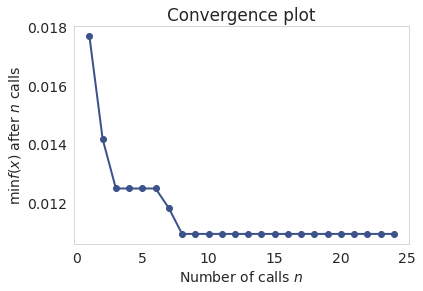

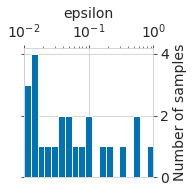

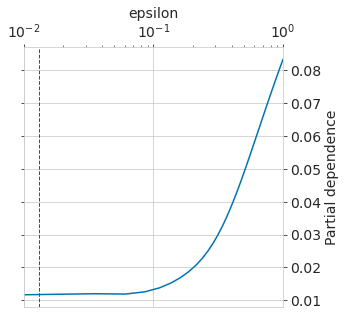

In [72]:
# Примечание: на графиках значения среднего реворда указаны со знаком минус
show_results(mcc_result, optimal_mcc_params)

#### Обучение стратегии алгоритмом on-policy Monte Carlo control

In [73]:
TRAIN_ITER = int(2e7)
EVAL_ITER = int(1e6)
N_JOBS = 40
NUM_CHECKPOINTS = 20

In [74]:
describe_train_params()

Параметры процедуры обчения Q-функции
Число эпох: 20
Число процессов для обучения алгоритма: 40
Число процессов для оценки алгоритма: 40
Общее число итераций обучения: 2.00e+07
Общее число итераций обучения на одной эпохе: 1.00e+06
Число итераций обучения на одной эпохе в одном процессе: 2.50e+04
Число итераций валидации на одном запуске: 1.00e+06
Однопоточный эквивалент общего числа итераций: 2.05e+07
Общее число задействованных процессов: 40


In [75]:
mcc_trainer = MccTrainer(env, best_mcc_epsilon)

In [76]:
mcc_Q, mcc_mean, mcc_std = train_and_eval(mcc_trainer, TRAIN_ITER, EVAL_ITER, NUM_CHECKPOINTS, N_JOBS)

Trainer: MccTrainer(epsilon=0.013092241632609372)
Training EpsilonGreedyStrategy(epsilon=0.013), evaluating GreedyStrategy


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.014449 +/- 0.001252


Epoch:   5%|▌         | 1/20 [03:26<1:05:19, 206.30s/it]

Epoch 2 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.013471 +/- 0.000935


Epoch:  10%|█         | 2/20 [06:49<1:01:38, 205.50s/it]

Epoch 3 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.013151 +/- 0.001409


Epoch:  15%|█▌        | 3/20 [10:13<58:02, 204.86s/it]  

Epoch 4 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.013498 +/- 0.001177


Epoch:  20%|██        | 4/20 [13:40<54:49, 205.62s/it]

Epoch 5 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.013417 +/- 0.001347


Epoch:  25%|██▌       | 5/20 [17:06<51:23, 205.55s/it]

Epoch 6 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.013113 +/- 0.001074


Epoch:  30%|███       | 6/20 [20:30<47:52, 205.14s/it]

Epoch 7 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012804 +/- 0.001272


Epoch:  35%|███▌      | 7/20 [23:56<44:30, 205.40s/it]

Epoch 8 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012614 +/- 0.001412


Epoch:  40%|████      | 8/20 [27:22<41:06, 205.51s/it]

Epoch 9 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.013195 +/- 0.001265


Epoch:  45%|████▌     | 9/20 [30:46<37:35, 205.06s/it]

Epoch 10 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012603 +/- 0.001116


Epoch:  50%|█████     | 10/20 [34:08<34:01, 204.17s/it]

Epoch 11 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012221 +/- 0.000864


Epoch:  55%|█████▌    | 11/20 [37:32<30:38, 204.31s/it]

Epoch 12 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012487 +/- 0.000934


Epoch:  60%|██████    | 12/20 [40:55<27:11, 203.93s/it]

Epoch 13 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012613 +/- 0.000826


Epoch:  65%|██████▌   | 13/20 [44:20<23:48, 204.06s/it]

Epoch 14 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012667 +/- 0.001105


Epoch:  70%|███████   | 14/20 [47:44<20:23, 203.99s/it]

Epoch 15 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012059 +/- 0.001052


Epoch:  75%|███████▌  | 15/20 [51:04<16:54, 202.91s/it]

Epoch 16 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012299 +/- 0.001018


Epoch:  80%|████████  | 16/20 [54:27<13:31, 202.98s/it]

Epoch 17 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012235 +/- 0.001207


Epoch:  85%|████████▌ | 17/20 [57:52<10:10, 203.57s/it]

Epoch 18 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012252 +/- 0.001112


Epoch:  90%|█████████ | 18/20 [1:01:15<06:47, 203.52s/it]

Epoch 19 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.012104 +/- 0.001012


Epoch:  95%|█████████▌| 19/20 [1:04:37<03:23, 203.02s/it]

Epoch 20 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.011953 +/- 0.000961


Epoch: 100%|██████████| 20/20 [1:07:59<00:00, 203.99s/it]


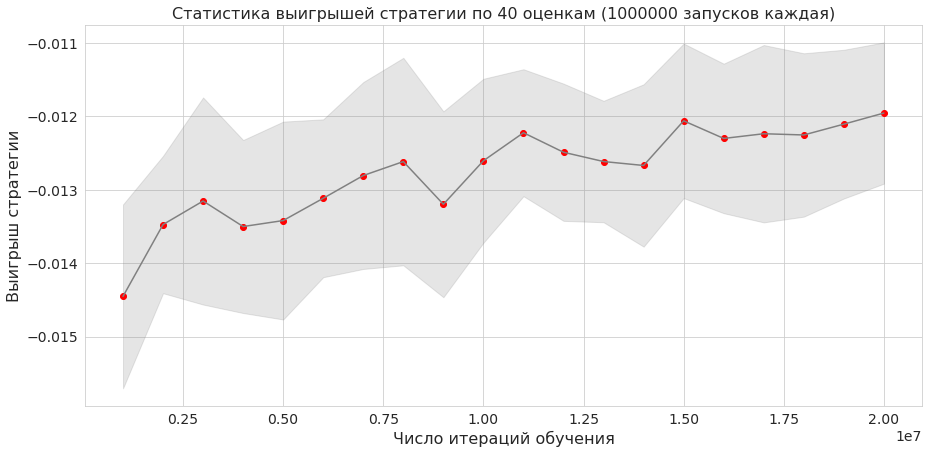

In [77]:
plot_returns(mcc_mean, mcc_std, TRAIN_ITER, EVAL_ITER, NUM_CHECKPOINTS, N_JOBS)

In [78]:
print(mcc_Q.show(20))

RunningMeans(total=27572917, unique=840 [top 20]
	(FullState(player_sum=21, dealer_card=7, usable_ace=True), 0)	1.347639	n=79538)
	(FullState(player_sum=21, dealer_card=9, usable_ace=True), 0)	1.345718	n=83276)
	(FullState(player_sum=21, dealer_card=8, usable_ace=True), 0)	1.344318	n=81329)
	(FullState(player_sum=21, dealer_card=6, usable_ace=True), 0)	1.341171	n=74684)
	(FullState(player_sum=21, dealer_card=5, usable_ace=True), 0)	1.331472	n=73166)
	(FullState(player_sum=21, dealer_card=3, usable_ace=True), 0)	1.321802	n=73048)
	(FullState(player_sum=21, dealer_card=4, usable_ace=True), 0)	1.307010	n=76587)
	(FullState(player_sum=21, dealer_card=2, usable_ace=True), 0)	1.291586	n=77857)
	(FullState(player_sum=21, dealer_card=10, usable_ace=True), 0)	1.257376	n=347288)
	(FullState(player_sum=21, dealer_card=9, usable_ace=False), 0)	0.940062	n=65451)
	(FullState(player_sum=21, dealer_card=8, usable_ace=False), 0)	0.930411	n=63990)
	(FullState(player_sum=21, dealer_card=7, usable_ace=Fal

Проигрывать стали в 2+ раза меньше!

#### Подбор гиперпараметров для Q-learning

In [79]:
epsilon_space = Real(0.01, 1, prior='log-uniform', name='epsilon')
alpha_space = Real(5e-4, 0.5, prior='log-uniform', name='alpha')
qlearning_space = [epsilon_space, alpha_space]

In [80]:
qlearning_estimator = QlearningHyperparametersEstimator(env, OPT_TRAIN_EPOCH_ITER, OPT_EVAL_ITER,
                                                        OPT_TRAIN_EPOCHS, NUM_ESTIMATE_PROCESS)

In [81]:
qlearning_result, optimal_qlearning_params = get_optimal_parameters(qlearning_estimator,
                                                                    qlearning_space,
                                                                    NUM_PARALLEL_POINTS,
                                                                    OPT_ITERATIONS)

Searching for optimal values of:
	"epsilon" in space Real(low=0.01, high=1, prior='log-uniform', transform='identity')
	"alpha" in space Real(low=0.0005, high=0.5, prior='log-uniform', transform='identity')


OptIter: 100%|██████████| 6/6 [1:38:18<00:00, 983.07s/it] 


In [82]:
best_qlearning_epsilon = optimal_qlearning_params['epsilon']
best_qlearning_alpha = optimal_qlearning_params['alpha']

Best mean reward: -0.011015
Optimal parameters:
	epsilon	= 1.000000
	alpha	= 0.005527


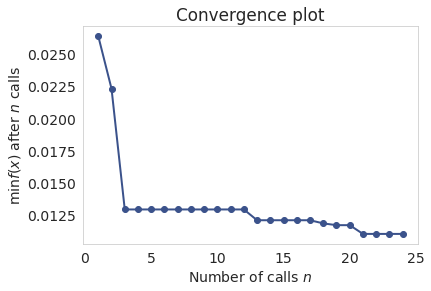

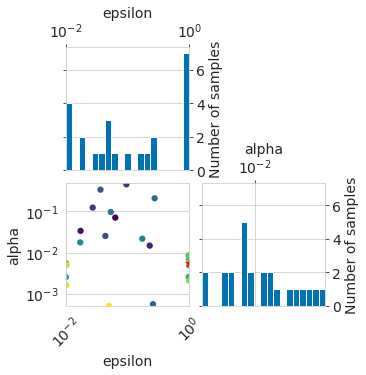

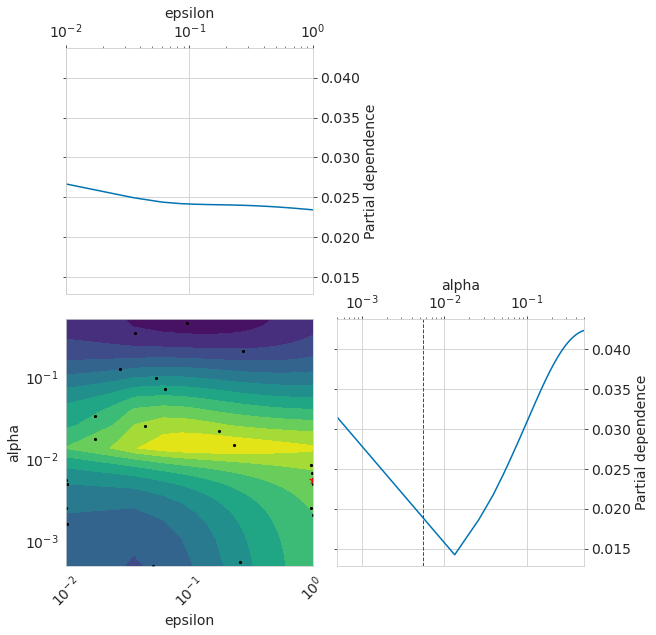

In [83]:
# Примечание: на графиках значения среднего реворда указаны со знаком минус
show_results(qlearning_result, optimal_qlearning_params)

Интересно, что оптимальный $\varepsilon=1$. Впрочем, это не очень удивительно, учитывая, что Q-learning является off-policy алгоритмом, а $\varepsilon=1$ обеспечивает наилучший exploration.

#### Обучение стратегии алгоритмом Q-learning

In [84]:
qlearning_trainer = QlearningTrainer(env, best_qlearning_epsilon, best_qlearning_alpha)

In [85]:
qlearning_Q, qlearning_mean, qlearning_std = train_and_eval(qlearning_trainer,
                                                            TRAIN_ITER,
                                                            EVAL_ITER,
                                                            NUM_CHECKPOINTS,
                                                            N_JOBS)

Trainer: QlearningTrainer(epsilon=1.0, alpha=0.005526780248947697)
Training EpsilonGreedyStrategy(epsilon=1.0), evaluating GreedyStrategy


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.047591 +/- 0.001262


Epoch:   5%|▌         | 1/20 [03:37<1:08:53, 217.56s/it]

Epoch 2 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.041314 +/- 0.001103


Epoch:  10%|█         | 2/20 [07:16<1:05:25, 218.11s/it]

Epoch 3 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.035157 +/- 0.001064


Epoch:  15%|█▌        | 3/20 [10:56<1:01:55, 218.57s/it]

Epoch 4 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.031910 +/- 0.000926


Epoch:  20%|██        | 4/20 [14:35<58:18, 218.68s/it]  

Epoch 5 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.026548 +/- 0.000986


Epoch:  25%|██▌       | 5/20 [18:13<54:35, 218.35s/it]

Epoch 6 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.024229 +/- 0.001232


Epoch:  30%|███       | 6/20 [21:48<50:43, 217.40s/it]

Epoch 7 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.022908 +/- 0.001009


Epoch:  35%|███▌      | 7/20 [25:27<47:12, 217.88s/it]

Epoch 8 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.021853 +/- 0.001226


Epoch:  40%|████      | 8/20 [29:02<43:23, 216.99s/it]

Epoch 9 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.021032 +/- 0.000840


Epoch:  45%|████▌     | 9/20 [32:38<39:44, 216.81s/it]

Epoch 10 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.019369 +/- 0.001239


Epoch:  50%|█████     | 10/20 [36:10<35:52, 215.28s/it]

Epoch 11 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.017485 +/- 0.001154


Epoch:  55%|█████▌    | 11/20 [39:42<32:10, 214.50s/it]

Epoch 12 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.016491 +/- 0.001165


Epoch:  60%|██████    | 12/20 [43:12<28:24, 213.07s/it]

Epoch 13 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.016291 +/- 0.001020


Epoch:  65%|██████▌   | 13/20 [46:43<24:46, 212.37s/it]

Epoch 14 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.016204 +/- 0.001123


Epoch:  70%|███████   | 14/20 [50:14<21:11, 211.90s/it]

Epoch 15 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.015420 +/- 0.001129


Epoch:  75%|███████▌  | 15/20 [53:42<17:34, 210.93s/it]

Epoch 16 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.015470 +/- 0.001302


Epoch:  80%|████████  | 16/20 [57:08<13:57, 209.29s/it]

Epoch 17 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.015484 +/- 0.000914


Epoch:  85%|████████▌ | 17/20 [1:00:32<10:23, 207.85s/it]

Epoch 18 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.015318 +/- 0.000935


Epoch:  90%|█████████ | 18/20 [1:03:59<06:55, 207.62s/it]

Epoch 19 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.014763 +/- 0.001058


Epoch:  95%|█████████▌| 19/20 [1:07:29<03:28, 208.05s/it]

Epoch 20 of 20 (1000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.014473 +/- 0.001119


Epoch: 100%|██████████| 20/20 [1:10:54<00:00, 212.72s/it]


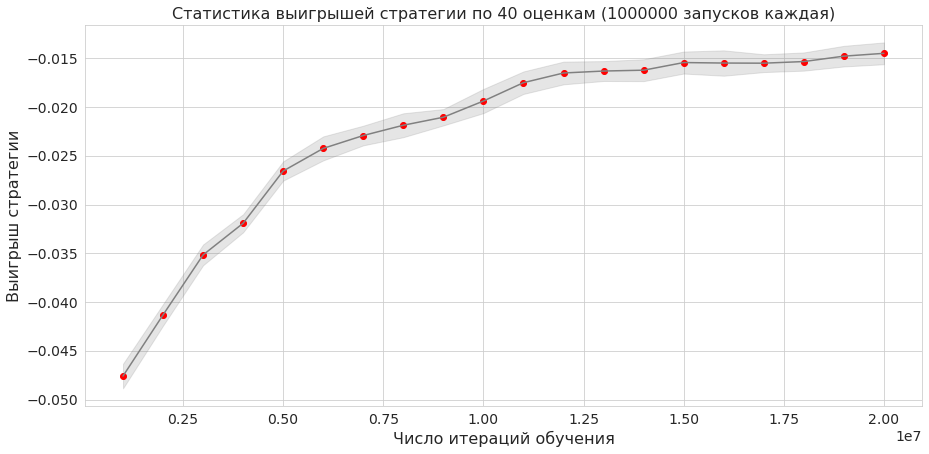

In [86]:
plot_returns(qlearning_mean, qlearning_std, TRAIN_ITER, EVAL_ITER, NUM_CHECKPOINTS, N_JOBS)

In [87]:
print(qlearning_Q.show(20))

RunningExp(alpha=0.005526780248947697, total=24684232, unique=840 [top 20]
	(FullState(player_sum=21, dealer_card=9, usable_ace=True), 0)	1.364801	n=26367)
	(FullState(player_sum=21, dealer_card=8, usable_ace=True), 0)	1.360618	n=26289)
	(FullState(player_sum=21, dealer_card=7, usable_ace=True), 0)	1.353035	n=26290)
	(FullState(player_sum=21, dealer_card=6, usable_ace=True), 0)	1.313151	n=26380)
	(FullState(player_sum=21, dealer_card=5, usable_ace=True), 0)	1.302479	n=26644)
	(FullState(player_sum=21, dealer_card=10, usable_ace=True), 0)	1.297815	n=105033)
	(FullState(player_sum=21, dealer_card=3, usable_ace=True), 0)	1.296250	n=26348)
	(FullState(player_sum=21, dealer_card=4, usable_ace=True), 0)	1.292451	n=26670)
	(FullState(player_sum=21, dealer_card=2, usable_ace=True), 0)	1.286600	n=26293)
	(FullState(player_sum=12, dealer_card=6, usable_ace=True), 1)	1.098116	n=3026)
	(FullState(player_sum=12, dealer_card=2, usable_ace=True), 1)	0.946453	n=3099)
	(FullState(player_sum=21, dealer_

В этот раз Q-learning при том же числе итераций немного отстаёт

# Часть третья, в главной роли — Дастин Хоффман
## Пункты 6 и 7
>6. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в
котором игрок имеет возможность “считать карты” в колоде. Это можно сделать
разными способами; возможно, вам поможет статья википедии о блекджеке (а
возможно, и нет).
>7. Реализуйте метод обучения с подкреплением без модели для этого варианта,
постройте графики, аналогичные п.2.  

Чтобы от подсчёта карт была какая-то польза, нужно смоделировать конечную колоду. Окружение позволяет задать произвольное число колод, но я проводил эксперименты только с одной колодой.  
В качестве стратегии подсчёта по умолчанию реализуется [Uston APC](https://www.qfit.com/cardcounting/Uston-APC/) с дополнительным счётчиком тузов. Это обеспечивает высокие Playing Efficiency и Betting Correlation, однако также раздувает пространство состояний в $105 \cdot 5 = 525$ раз.  
В моей реализации подсчёта игрок _не видит_ скрытую карту дилера до самого конца эпизода, сразу после окончания эпизода она всё же участвует в подсчёте.

In [88]:
from card_counting_blackjack import CardCountingBlackjackEnv

In [89]:
@dataclass(frozen=True)
class CountState:
    player_sum: int   # Player's sum
    dealer_card: int  # Dealer's open card
    usable_ace: bool  # Does player have usable ace?
    count: int        # Running Uston APC count
    aces: int         # Number of aces out

In [90]:
def counting_state_getter(gym_state: Tuple, env: gym.Env) -> CountState:
    """Оборачивает состояние из gym.Env в CountState"""
    return CountState(*gym_state)

In [91]:
env = EnvironmentWrapper(CardCountingBlackjackEnv(num_decks=1, reshuffle_at=15, natural=True),
                         state_getter=counting_state_getter)

#### Подбор гиперпараметров для on-policy Monte Carlo control

In [92]:
OPT_ITERATIONS = 5
NUM_PARALLEL_POINTS = 4
NUM_ESTIMATE_PROCESS = 10
OPT_TRAIN_EPOCHS = 30
OPT_TRAIN_EPOCH_ITER = int(3e6)
OPT_EVAL_ITER = int(1e6)

In [93]:
describe_opt_params()

Параметры процедуры подбора гиперпараметров
Общее число оцениваемых точек: 20
Число итераций процедуры байесовской оптимизации: 5
Число параллельно оцениваемых точек на одной итерации: 4
Число процессов для обучения одного алгоритма: 10
Число эпох обучения: 30
Число итераций обучения на одной эпохе в одном процессе: 3.00e+05
Общее число итераций обучения на одной эпохе: 3.00e+06
Общее число итераций обучения: 9.00e+07
Число параллельных запусков валидации: 10
Число итераций валидации на одном запуске: 1.00e+06
Однопоточный эквивалент общего числа итераций: 5.00e+07
Общее число задействованных процессов: 40


In [94]:
epsilon_space = Real(0.01, 1, prior='log-uniform', name='epsilon')
mcc_space = [epsilon_space]

In [95]:
mcc_estimator = MccHyperparametersEstimator(env, OPT_TRAIN_EPOCH_ITER, OPT_EVAL_ITER, OPT_TRAIN_EPOCHS, NUM_ESTIMATE_PROCESS)

In [96]:
mcc_result, optimal_mcc_params = get_optimal_parameters(mcc_estimator, mcc_space, NUM_PARALLEL_POINTS, OPT_ITERATIONS)

Searching for optimal values of:
	"epsilon" in space Real(low=0.01, high=1, prior='log-uniform', transform='identity')


OptIter: 100%|██████████| 5/5 [4:22:21<00:00, 3148.34s/it]  


In [97]:
best_mcc_epsilon = optimal_mcc_params['epsilon']

Best mean reward: -0.009782
Optimal parameters:
	epsilon	= 0.094882


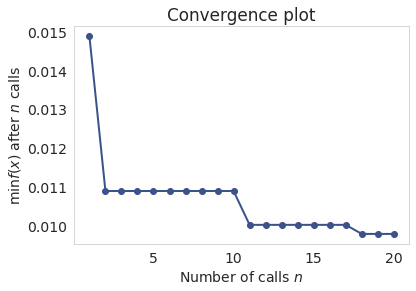

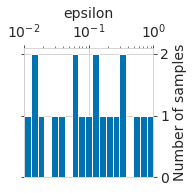

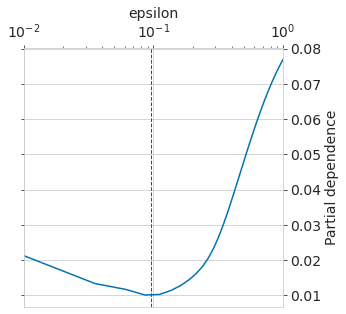

In [98]:
# Примечание: на графиках значения среднего реворда указаны со знаком минус
show_results(mcc_result, optimal_mcc_params)

#### Обучение стратегии алгоритмом on-policy Monte Carlo control

In [103]:
TRAIN_ITER = int(2e9)
EVAL_ITER = int(1e6)
N_JOBS = 40
NUM_CHECKPOINTS = 40

In [104]:
describe_train_params()

Параметры процедуры обчения Q-функции
Число эпох: 40
Число процессов для обучения алгоритма: 40
Число процессов для оценки алгоритма: 40
Общее число итераций обучения: 2.00e+09
Общее число итераций обучения на одной эпохе: 5.00e+07
Число итераций обучения на одной эпохе в одном процессе: 1.25e+06
Число итераций валидации на одном запуске: 1.00e+06
Однопоточный эквивалент общего числа итераций: 9.00e+07
Общее число задействованных процессов: 40


In [105]:
mcc_trainer = MccTrainer(env, best_mcc_epsilon)

In [106]:
mcc_Q, mcc_mean, mcc_std = train_and_eval(mcc_trainer, TRAIN_ITER, EVAL_ITER, NUM_CHECKPOINTS, N_JOBS)

Trainer: MccTrainer(epsilon=0.09488161911471774)
Training EpsilonGreedyStrategy(epsilon=0.095), evaluating GreedyStrategy


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.015575 +/- 0.001243


Epoch:   2%|▎         | 1/40 [08:44<5:41:08, 524.84s/it]

Epoch 2 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.009834 +/- 0.001261


Epoch:   5%|▌         | 2/40 [18:15<5:41:05, 538.55s/it]

Epoch 3 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.008107 +/- 0.000931


Epoch:   8%|▊         | 3/40 [28:00<5:40:44, 552.56s/it]

Epoch 4 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.006778 +/- 0.001234


Epoch:  10%|█         | 4/40 [37:37<5:35:57, 559.93s/it]

Epoch 5 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.006127 +/- 0.001239


Epoch:  12%|█▎        | 5/40 [47:23<5:31:05, 567.59s/it]

Epoch 6 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.005307 +/- 0.001049


Epoch:  15%|█▌        | 6/40 [57:07<5:24:23, 572.45s/it]

Epoch 7 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.005321 +/- 0.001173


Epoch:  18%|█▊        | 7/40 [1:06:55<5:17:24, 577.11s/it]

Epoch 8 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.004629 +/- 0.001098


Epoch:  20%|██        | 8/40 [1:16:44<5:09:42, 580.69s/it]

Epoch 9 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.004448 +/- 0.000837


Epoch:  22%|██▎       | 9/40 [1:26:38<5:02:13, 584.95s/it]

Epoch 10 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.004115 +/- 0.001132


Epoch:  25%|██▌       | 10/40 [1:36:33<4:53:55, 587.84s/it]

Epoch 11 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003818 +/- 0.001153


Epoch:  28%|██▊       | 11/40 [1:46:21<4:44:10, 587.96s/it]

Epoch 12 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003847 +/- 0.001164


Epoch:  30%|███       | 12/40 [1:56:27<4:36:49, 593.21s/it]

Epoch 13 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003683 +/- 0.000994


Epoch:  32%|███▎      | 13/40 [2:06:16<4:26:23, 591.98s/it]

Epoch 14 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003588 +/- 0.001060


Epoch:  35%|███▌      | 14/40 [2:16:02<4:15:43, 590.14s/it]

Epoch 15 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003088 +/- 0.001025


Epoch:  38%|███▊      | 15/40 [2:25:53<4:06:01, 590.48s/it]

Epoch 16 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003041 +/- 0.000977


Epoch:  40%|████      | 16/40 [2:35:40<3:55:44, 589.34s/it]

Epoch 17 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002938 +/- 0.001300


Epoch:  42%|████▎     | 17/40 [2:45:32<3:46:17, 590.33s/it]

Epoch 18 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002925 +/- 0.000978


Epoch:  45%|████▌     | 18/40 [2:55:18<3:35:59, 589.07s/it]

Epoch 19 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003238 +/- 0.001019


Epoch:  48%|████▊     | 19/40 [3:05:19<3:27:25, 592.62s/it]

Epoch 20 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002980 +/- 0.001057


Epoch:  50%|█████     | 20/40 [3:15:18<3:18:06, 594.31s/it]

Epoch 21 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003057 +/- 0.001411


Epoch:  52%|█████▎    | 21/40 [3:25:18<3:08:48, 596.22s/it]

Epoch 22 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002669 +/- 0.001132


Epoch:  55%|█████▌    | 22/40 [3:35:19<2:59:18, 597.70s/it]

Epoch 23 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002799 +/- 0.001146


Epoch:  57%|█████▊    | 23/40 [3:45:12<2:48:53, 596.12s/it]

Epoch 24 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002814 +/- 0.001279


Epoch:  60%|██████    | 24/40 [3:55:08<2:38:58, 596.18s/it]

Epoch 25 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002803 +/- 0.001018


Epoch:  62%|██████▎   | 25/40 [4:05:11<2:29:33, 598.25s/it]

Epoch 26 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002798 +/- 0.001181


Epoch:  65%|██████▌   | 26/40 [4:15:05<2:19:17, 596.97s/it]

Epoch 27 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002303 +/- 0.001216


Epoch:  68%|██████▊   | 27/40 [4:25:03<2:09:23, 597.22s/it]

Epoch 28 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002597 +/- 0.001023


Epoch:  70%|███████   | 28/40 [4:35:11<2:00:06, 600.53s/it]

Epoch 29 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002426 +/- 0.001183


Epoch:  72%|███████▎  | 29/40 [4:45:10<1:49:58, 599.89s/it]

Epoch 30 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002612 +/- 0.000974


Epoch:  75%|███████▌  | 30/40 [4:55:17<1:40:21, 602.11s/it]

Epoch 31 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002491 +/- 0.001038


Epoch:  78%|███████▊  | 31/40 [5:05:13<1:30:02, 600.30s/it]

Epoch 32 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002272 +/- 0.001317


Epoch:  80%|████████  | 32/40 [5:15:17<1:20:11, 601.47s/it]

Epoch 33 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002487 +/- 0.001177


Epoch:  82%|████████▎ | 33/40 [5:25:37<1:10:49, 607.02s/it]

Epoch 34 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002174 +/- 0.001167


Epoch:  85%|████████▌ | 34/40 [5:35:41<1:00:36, 606.04s/it]

Epoch 35 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002153 +/- 0.001347


Epoch:  88%|████████▊ | 35/40 [5:45:57<50:45, 609.16s/it]  

Epoch 36 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002386 +/- 0.001003


Epoch:  90%|█████████ | 36/40 [5:56:11<40:42, 610.52s/it]

Epoch 37 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002423 +/- 0.001254


Epoch:  92%|█████████▎| 37/40 [6:06:18<30:28, 609.42s/it]

Epoch 38 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002307 +/- 0.001276


Epoch:  95%|█████████▌| 38/40 [6:16:29<20:19, 609.77s/it]

Epoch 39 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002148 +/- 0.001105


Epoch:  98%|█████████▊| 39/40 [6:26:53<10:14, 614.33s/it]

Epoch 40 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002277 +/- 0.000970


Epoch: 100%|██████████| 40/40 [6:37:04<00:00, 595.60s/it]


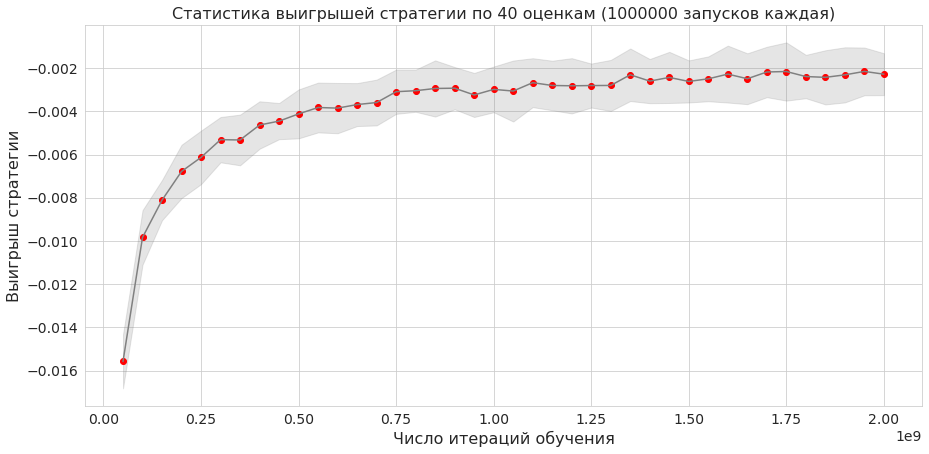

In [107]:
plot_returns(mcc_mean, mcc_std, TRAIN_ITER, EVAL_ITER, NUM_CHECKPOINTS, N_JOBS)

In [108]:
print(mcc_Q.show(20))

RunningMeans(total=2705084971, unique=266841 [top 20]
	(CountState(player_sum=11, dealer_card=5, usable_ace=False, count=40, aces=3), 2)	2.000000	n=17)
	(CountState(player_sum=9, dealer_card=3, usable_ace=False, count=42, aces=1), 2)	2.000000	n=3)
	(CountState(player_sum=10, dealer_card=4, usable_ace=False, count=39, aces=0), 2)	2.000000	n=4)
	(CountState(player_sum=4, dealer_card=7, usable_ace=False, count=-27, aces=2), 2)	2.000000	n=2)
	(CountState(player_sum=18, dealer_card=2, usable_ace=True, count=42, aces=1), 2)	2.000000	n=2)
	(CountState(player_sum=13, dealer_card=3, usable_ace=False, count=-32, aces=0), 2)	2.000000	n=1)
	(CountState(player_sum=14, dealer_card=6, usable_ace=True, count=38, aces=4), 2)	2.000000	n=3)
	(CountState(player_sum=11, dealer_card=8, usable_ace=False, count=38, aces=0), 2)	2.000000	n=9)
	(CountState(player_sum=5, dealer_card=5, usable_ace=False, count=39, aces=1), 2)	2.000000	n=5)
	(CountState(player_sum=11, dealer_card=4, usable_ace=False, count=39, aces

Проигрывать стали ещё в 5+ раз меньше, но всё-таки в ноль не вышли

#### Подбор гиперпараметров для Q-learning

In [109]:
epsilon_space = Real(0.01, 1, prior='log-uniform', name='epsilon')
alpha_space = Real(5e-4, 0.5, prior='log-uniform', name='alpha')
qlearning_space = [epsilon_space, alpha_space]

In [110]:
qlearning_estimator = QlearningHyperparametersEstimator(env, OPT_TRAIN_EPOCH_ITER, OPT_EVAL_ITER,
                                                        OPT_TRAIN_EPOCHS, NUM_ESTIMATE_PROCESS)

In [111]:
qlearning_result, optimal_qlearning_params = get_optimal_parameters(qlearning_estimator,
                                                                    qlearning_space,
                                                                    NUM_PARALLEL_POINTS,
                                                                    OPT_ITERATIONS)

Searching for optimal values of:
	"epsilon" in space Real(low=0.01, high=1, prior='log-uniform', transform='identity')
	"alpha" in space Real(low=0.0005, high=0.5, prior='log-uniform', transform='identity')


OptIter: 100%|██████████| 5/5 [4:50:34<00:00, 3486.95s/it]  


In [112]:
best_qlearning_epsilon = optimal_qlearning_params['epsilon']
best_qlearning_alpha = optimal_qlearning_params['alpha']

Best mean reward: -0.006782
Optimal parameters:
	epsilon	= 1.000000
	alpha	= 0.048187


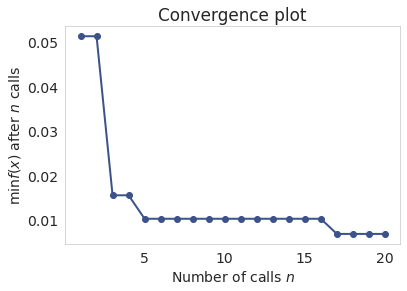

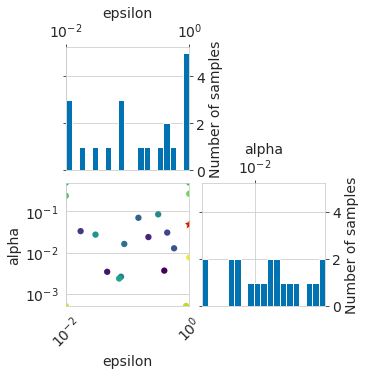

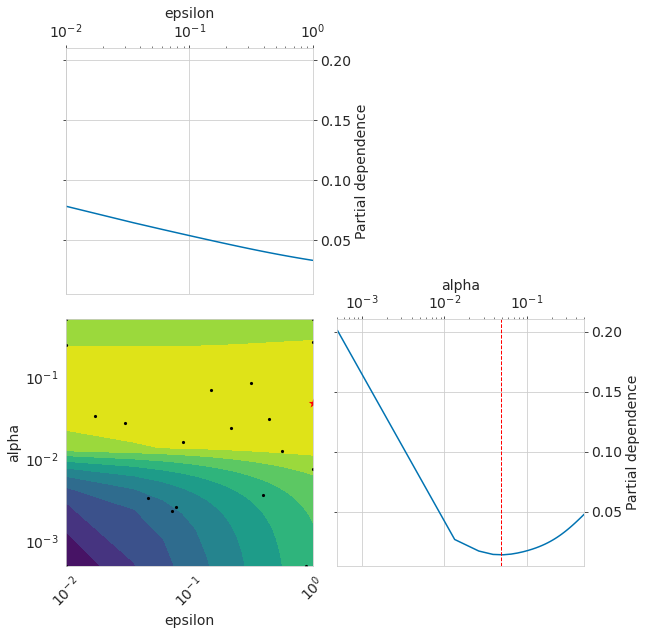

In [113]:
# Примечание: на графиках значения среднего реворда указаны со знаком минус
show_results(qlearning_result, optimal_qlearning_params)

#### Обучение стратегии алгоритмом Q-learning

In [114]:
qlearning_trainer = QlearningTrainer(env, best_qlearning_epsilon, best_qlearning_alpha)

In [ ]:
qlearning_Q, qlearning_mean, qlearning_std = train_and_eval(qlearning_trainer,
                                                            TRAIN_ITER,
                                                            EVAL_ITER,
                                                            NUM_CHECKPOINTS,
                                                            N_JOBS)

Trainer: QlearningTrainer(epsilon=1.0, alpha=0.048187141130215064)
Training EpsilonGreedyStrategy(epsilon=1.0), evaluating GreedyStrategy


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.021602 +/- 0.000988


Epoch:   2%|▎         | 1/40 [09:26<6:08:32, 566.99s/it]

Epoch 2 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.011812 +/- 0.001257


Epoch:   5%|▌         | 2/40 [19:43<6:08:29, 581.83s/it]

Epoch 3 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.008524 +/- 0.000999


Epoch:   8%|▊         | 3/40 [29:53<6:03:58, 590.22s/it]

Epoch 4 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.005287 +/- 0.000668


Epoch:  10%|█         | 4/40 [40:18<6:00:29, 600.82s/it]

Epoch 5 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.004328 +/- 0.001173


Epoch:  12%|█▎        | 5/40 [50:19<5:50:28, 600.81s/it]

Epoch 6 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003716 +/- 0.001066


Epoch:  15%|█▌        | 6/40 [1:00:27<5:41:41, 602.99s/it]

Epoch 7 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002968 +/- 0.000950


Epoch:  18%|█▊        | 7/40 [1:10:35<5:32:22, 604.31s/it]

Epoch 8 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002707 +/- 0.000908


Epoch:  20%|██        | 8/40 [1:20:32<5:21:12, 602.27s/it]

Epoch 9 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002694 +/- 0.001148


Epoch:  22%|██▎       | 9/40 [1:30:48<5:13:16, 606.33s/it]

Epoch 10 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002102 +/- 0.001110


Epoch:  25%|██▌       | 10/40 [1:41:08<5:05:17, 610.59s/it]

Epoch 11 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002122 +/- 0.000938


Epoch:  28%|██▊       | 11/40 [1:51:28<4:56:29, 613.43s/it]

Epoch 12 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002050 +/- 0.001150


Epoch:  30%|███       | 12/40 [2:01:44<4:46:36, 614.15s/it]

Epoch 13 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001953 +/- 0.001304


Epoch:  32%|███▎      | 13/40 [2:11:56<4:36:05, 613.55s/it]

Epoch 14 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001737 +/- 0.001094


Epoch:  35%|███▌      | 14/40 [2:22:19<4:27:04, 616.31s/it]

Epoch 15 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001678 +/- 0.001060


Epoch:  38%|███▊      | 15/40 [2:32:37<4:17:02, 616.91s/it]

Epoch 16 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001290 +/- 0.001255


Epoch:  40%|████      | 16/40 [2:42:51<4:06:20, 615.86s/it]

Epoch 17 of 40 (50000000 runs)


Здесь у меня отвалилось соединение до kernel, так что часть вывода потерялась

In [122]:
qlearning_mean[-10:]

[-0.000752825,
 -0.0005653625,
 -0.0010540624999999999,
 -0.0010335125,
 -0.0006654624999999999,
 -0.0008354250000000001,
 -0.00102755,
 -0.0007910375,
 -0.0008355125000000001,
 -0.0008136375000000001]

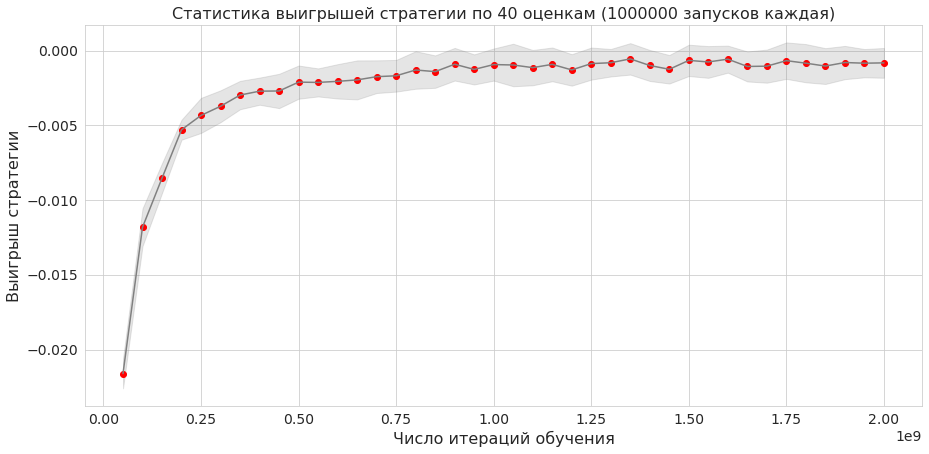

In [118]:
plot_returns(qlearning_mean, qlearning_std, TRAIN_ITER, EVAL_ITER, NUM_CHECKPOINTS, N_JOBS)

In [119]:
print(qlearning_Q.show(20))

RunningExp(alpha=0.048187141130215064, total=2471286369, unique=272985 [top 20]
	(CountState(player_sum=5, dealer_card=6, usable_ace=False, count=-27, aces=2), 1)	2.000000	n=1)
	(CountState(player_sum=16, dealer_card=2, usable_ace=True, count=37, aces=1), 2)	2.000000	n=5)
	(CountState(player_sum=11, dealer_card=5, usable_ace=False, count=39, aces=1), 2)	2.000000	n=10)
	(CountState(player_sum=21, dealer_card=8, usable_ace=True, count=39, aces=1), 2)	2.000000	n=2)
	(CountState(player_sum=17, dealer_card=5, usable_ace=True, count=37, aces=4), 2)	2.000000	n=5)
	(CountState(player_sum=9, dealer_card=4, usable_ace=False, count=39, aces=3), 2)	2.000000	n=8)
	(CountState(player_sum=9, dealer_card=5, usable_ace=False, count=44, aces=4), 2)	2.000000	n=1)
	(CountState(player_sum=14, dealer_card=6, usable_ace=True, count=-26, aces=4), 2)	2.000000	n=1)
	(CountState(player_sum=4, dealer_card=5, usable_ace=False, count=39, aces=4), 1)	2.000000	n=1)
	(CountState(player_sum=4, dealer_card=6, usable_ace

В этот раз Q-learning показал себя в 2.5+ раза лучше, чем MCC!  
Однако выйти в 0 всё равно не удалось.  
Возможно, это связано с тем, что пространство пар (состояние, действие) получилось слишком большим, и некоторые из них мы даже не посетили. Попробуем использовать более простую технику подсчёта - [REKO](https://www.qfit.com/cardcounting/REKO/), без дополнительного счётчика тузов.  Тогда вместо множителя $105 \cdot 5 = 525$ к пространству состояний-действий получим всего $24+20+1 = 45$, т.е. на порядок меньше

In [127]:
from importlib import reload

import card_counting_blackjack

reload(card_counting_blackjack)
import card_counting_blackjack
from card_counting_blackjack import CardCountingBlackjackEnv

In [128]:
@dataclass(frozen=True)
class RekoCountState:
    player_sum: int   # Player's sum
    dealer_card: int  # Dealer's open card
    usable_ace: bool  # Does player have usable ace?
    count: int        # Running REKO count

In [129]:
def reko_counting_state_getter(gym_state: Tuple, env: gym.Env) -> RekoCountState:
    return RekoCountState(*gym_state)

In [130]:
env = EnvironmentWrapper(CardCountingBlackjackEnv(num_decks=1,
                                                    reshuffle_at=15,
                                                    natural=True,
                                                    counting_strategy='reko',
                                                    count_aces=False),
                         state_getter=reko_counting_state_getter)

In [131]:
reko_qlearning_trainer = QlearningTrainer(env, best_qlearning_epsilon, best_qlearning_alpha)

In [132]:
reko_qlearning_Q, reko_qlearning_mean, reko_qlearning_std = train_and_eval(reko_qlearning_trainer,
                                                                            TRAIN_ITER,
                                                                            EVAL_ITER,
                                                                            NUM_CHECKPOINTS,
                                                                            N_JOBS)

Trainer: QlearningTrainer(epsilon=1.0, alpha=0.048187141130215064)
Training EpsilonGreedyStrategy(epsilon=1.0), evaluating GreedyStrategy


Epoch:   0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003780 +/- 0.001227


Epoch:   2%|▎         | 1/40 [07:23<4:48:24, 443.71s/it]

Epoch 2 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003051 +/- 0.001079


Epoch:   5%|▌         | 2/40 [14:56<4:42:47, 446.52s/it]

Epoch 3 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002683 +/- 0.001193


Epoch:   8%|▊         | 3/40 [22:30<4:36:38, 448.61s/it]

Epoch 4 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002605 +/- 0.001167


Epoch:  10%|█         | 4/40 [30:03<4:30:01, 450.04s/it]

Epoch 5 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002428 +/- 0.001284


Epoch:  12%|█▎        | 5/40 [37:37<4:23:13, 451.23s/it]

Epoch 6 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002427 +/- 0.001112


Epoch:  15%|█▌        | 6/40 [45:05<4:15:11, 450.34s/it]

Epoch 7 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002443 +/- 0.001062


Epoch:  18%|█▊        | 7/40 [52:37<4:07:49, 450.58s/it]

Epoch 8 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002050 +/- 0.001143


Epoch:  20%|██        | 8/40 [1:00:07<4:00:12, 450.39s/it]

Epoch 9 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002130 +/- 0.001166


Epoch:  22%|██▎       | 9/40 [1:07:37<3:52:47, 450.56s/it]

Epoch 10 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002099 +/- 0.000841


Epoch:  25%|██▌       | 10/40 [1:15:06<3:45:02, 450.09s/it]

Epoch 11 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002430 +/- 0.000913


Epoch:  28%|██▊       | 11/40 [1:22:33<3:37:03, 449.09s/it]

Epoch 12 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002575 +/- 0.000897


Epoch:  30%|███       | 12/40 [1:29:56<3:28:40, 447.16s/it]

Epoch 13 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002454 +/- 0.001161


Epoch:  32%|███▎      | 13/40 [1:37:24<3:21:23, 447.53s/it]

Epoch 14 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002249 +/- 0.001250


Epoch:  35%|███▌      | 14/40 [1:44:55<3:14:23, 448.58s/it]

Epoch 15 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002196 +/- 0.001393


Epoch:  38%|███▊      | 15/40 [1:52:21<3:06:33, 447.72s/it]

Epoch 16 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001979 +/- 0.001069


Epoch:  40%|████      | 16/40 [1:59:47<2:58:54, 447.26s/it]

Epoch 17 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002405 +/- 0.000985


Epoch:  42%|████▎     | 17/40 [2:07:15<2:51:29, 447.36s/it]

Epoch 18 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001924 +/- 0.001212


Epoch:  45%|████▌     | 18/40 [2:14:40<2:43:49, 446.82s/it]

Epoch 19 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002331 +/- 0.001075


Epoch:  48%|████▊     | 19/40 [2:22:05<2:36:09, 446.18s/it]

Epoch 20 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002499 +/- 0.000854


Epoch:  50%|█████     | 20/40 [2:29:30<2:28:33, 445.68s/it]

Epoch 21 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002173 +/- 0.000939


Epoch:  52%|█████▎    | 21/40 [2:36:58<2:21:22, 446.46s/it]

Epoch 22 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002457 +/- 0.001002


Epoch:  55%|█████▌    | 22/40 [2:44:23<2:13:48, 446.04s/it]

Epoch 23 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002521 +/- 0.001223


Epoch:  57%|█████▊    | 23/40 [2:51:49<2:06:22, 446.03s/it]

Epoch 24 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002420 +/- 0.001114


Epoch:  60%|██████    | 24/40 [2:59:18<1:59:12, 447.02s/it]

Epoch 25 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002183 +/- 0.000881


Epoch:  62%|██████▎   | 25/40 [3:06:47<1:51:53, 447.54s/it]

Epoch 26 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002344 +/- 0.001156


Epoch:  65%|██████▌   | 26/40 [3:14:10<1:44:08, 446.32s/it]

Epoch 27 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002215 +/- 0.001144


Epoch:  68%|██████▊   | 27/40 [3:21:39<1:36:49, 446.90s/it]

Epoch 28 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002483 +/- 0.001263


Epoch:  70%|███████   | 28/40 [3:29:08<1:29:31, 447.59s/it]

Epoch 29 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002319 +/- 0.001161


Epoch:  72%|███████▎  | 29/40 [3:36:34<1:22:00, 447.28s/it]

Epoch 30 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002207 +/- 0.001082


Epoch:  75%|███████▌  | 30/40 [3:44:05<1:14:43, 448.39s/it]

Epoch 31 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001900 +/- 0.001252


Epoch:  78%|███████▊  | 31/40 [3:51:30<1:07:05, 447.29s/it]

Epoch 32 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002219 +/- 0.001097


Epoch:  80%|████████  | 32/40 [3:58:58<59:40, 447.59s/it]  

Epoch 33 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001974 +/- 0.001091


Epoch:  82%|████████▎ | 33/40 [4:06:20<51:59, 445.69s/it]

Epoch 34 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002343 +/- 0.000928


Epoch:  85%|████████▌ | 34/40 [4:13:45<44:32, 445.48s/it]

Epoch 35 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002172 +/- 0.000912


Epoch:  88%|████████▊ | 35/40 [4:21:13<37:12, 446.45s/it]

Epoch 36 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002448 +/- 0.000953


Epoch:  90%|█████████ | 36/40 [4:28:41<29:46, 446.74s/it]

Epoch 37 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002603 +/- 0.001086


Epoch:  92%|█████████▎| 37/40 [4:36:04<22:17, 445.74s/it]

Epoch 38 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001738 +/- 0.001059


Epoch:  95%|█████████▌| 38/40 [4:43:28<14:50, 445.18s/it]

Epoch 39 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002121 +/- 0.001117


Epoch:  98%|█████████▊| 39/40 [4:50:58<07:26, 446.65s/it]

Epoch 40 of 40 (50000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002352 +/- 0.001221


Epoch: 100%|██████████| 40/40 [4:58:24<00:00, 447.62s/it]


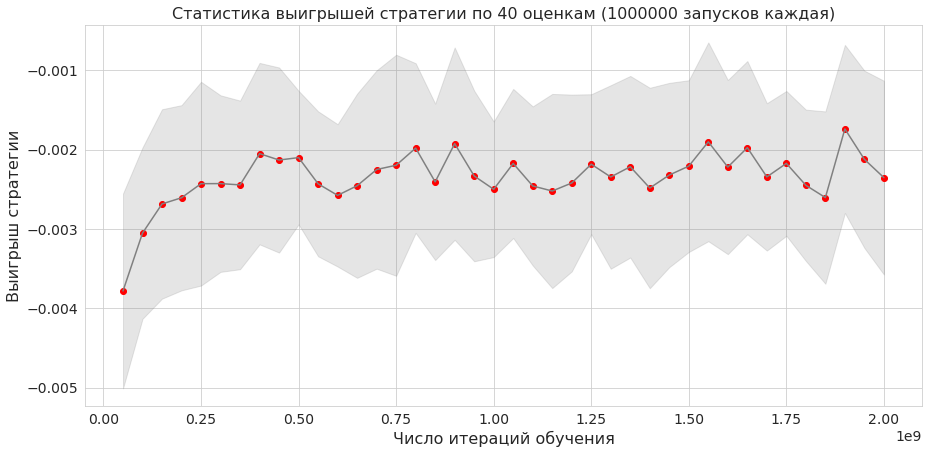

In [133]:
plot_returns(reko_qlearning_mean, reko_qlearning_std, TRAIN_ITER, EVAL_ITER, NUM_CHECKPOINTS, N_JOBS)

In [134]:
print(reko_qlearning_Q.show(20))

RunningExp(alpha=0.048187141130215064, total=2471320452, unique=25448 [top 20]
	(RekoCountState(player_sum=21, dealer_card=7, usable_ace=True, count=15), 2)	2.000000	n=12)
	(RekoCountState(player_sum=17, dealer_card=5, usable_ace=True, count=15), 2)	2.000000	n=4)
	(RekoCountState(player_sum=8, dealer_card=5, usable_ace=False, count=17), 2)	2.000000	n=3)
	(RekoCountState(player_sum=13, dealer_card=9, usable_ace=True, count=-11), 2)	2.000000	n=6)
	(RekoCountState(player_sum=17, dealer_card=2, usable_ace=False, count=-13), 2)	2.000000	n=1)
	(RekoCountState(player_sum=10, dealer_card=7, usable_ace=False, count=17), 2)	2.000000	n=9)
	(RekoCountState(player_sum=12, dealer_card=9, usable_ace=True, count=14), 2)	2.000000	n=2)
	(RekoCountState(player_sum=5, dealer_card=3, usable_ace=False, count=18), 2)	2.000000	n=1)
	(RekoCountState(player_sum=16, dealer_card=7, usable_ace=True, count=-11), 2)	2.000000	n=2)
	(RekoCountState(player_sum=14, dealer_card=7, usable_ace=True, count=16), 2)	2.000000	

Стало только хуже.  
Можно ещё попробовать использовать Uston APC без side-count для тузов. И прогнать побольше итераций.

In [138]:
env = EnvironmentWrapper(CardCountingBlackjackEnv(num_decks=1,
                                                    reshuffle_at=15,
                                                    natural=True,
                                                    counting_strategy='uston_apc',
                                                    count_aces=False),
                         state_getter=reko_counting_state_getter)

In [139]:
TRAIN_ITER = int(6e9)
EVAL_ITER = int(1e6)
N_JOBS = 40
NUM_CHECKPOINTS = 60

In [140]:
describe_train_params()

Параметры процедуры обчения Q-функции
Число эпох: 60
Число процессов для обучения алгоритма: 40
Число процессов для оценки алгоритма: 40
Общее число итераций обучения: 6.00e+09
Общее число итераций обучения на одной эпохе: 1.00e+08
Число итераций обучения на одной эпохе в одном процессе: 2.50e+06
Число итераций валидации на одном запуске: 1.00e+06
Однопоточный эквивалент общего числа итераций: 2.10e+08
Общее число задействованных процессов: 40


In [142]:
uston_qlearning_trainer = QlearningTrainer(env, epsilon=0.9, alpha=best_qlearning_alpha)

In [143]:
uston_qlearning_Q, uston_qlearning_mean, uston_qlearning_std = train_and_eval(uston_qlearning_trainer,
                                                                            TRAIN_ITER,
                                                                            EVAL_ITER,
                                                                            NUM_CHECKPOINTS,
                                                                            N_JOBS)

Trainer: QlearningTrainer(epsilon=0.9, alpha=0.048187141130215064)
Training EpsilonGreedyStrategy(epsilon=0.9), evaluating GreedyStrategy


Epoch:   0%|          | 0/60 [00:00<?, ?it/s]

Epoch 1 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.003574 +/- 0.001084


Epoch:   2%|▏         | 1/60 [13:21<13:08:28, 801.84s/it]

Epoch 2 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.002138 +/- 0.001065


Epoch:   3%|▎         | 2/60 [26:55<12:58:37, 805.48s/it]

Epoch 3 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001805 +/- 0.001115


Epoch:   5%|▌         | 3/60 [40:29<12:47:32, 807.95s/it]

Epoch 4 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001441 +/- 0.000791


Epoch:   7%|▋         | 4/60 [54:06<12:36:37, 810.66s/it]

Epoch 5 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001505 +/- 0.001014


Epoch:   8%|▊         | 5/60 [1:07:39<12:23:40, 811.29s/it]

Epoch 6 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.000875 +/- 0.001027


Epoch:  10%|█         | 6/60 [1:21:13<12:10:52, 812.08s/it]

Epoch 7 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001381 +/- 0.001177


Epoch:  12%|█▏        | 7/60 [1:34:34<11:54:21, 808.72s/it]

Epoch 8 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001398 +/- 0.001207


Epoch:  13%|█▎        | 8/60 [1:47:57<11:39:27, 807.07s/it]

Epoch 9 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001537 +/- 0.001131


Epoch:  15%|█▌        | 9/60 [2:01:26<11:26:31, 807.68s/it]

Epoch 10 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001096 +/- 0.001026


Epoch:  17%|█▋        | 10/60 [2:14:47<11:11:31, 805.83s/it]

Epoch 11 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001285 +/- 0.000943


Epoch:  18%|█▊        | 11/60 [2:28:13<10:58:07, 805.86s/it]

Epoch 12 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001401 +/- 0.001092


Epoch:  20%|██        | 12/60 [2:41:46<10:46:19, 807.90s/it]

Epoch 13 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001037 +/- 0.000972


Epoch:  22%|██▏       | 13/60 [2:55:06<10:30:55, 805.44s/it]

Epoch 14 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001572 +/- 0.000984


Epoch:  23%|██▎       | 14/60 [3:08:36<10:18:31, 806.78s/it]

Epoch 15 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001452 +/- 0.001147


Epoch:  25%|██▌       | 15/60 [3:21:59<10:04:26, 805.92s/it]

Epoch 16 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.000941 +/- 0.000970


Epoch:  27%|██▋       | 16/60 [3:35:24<9:50:37, 805.39s/it] 

Epoch 17 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001259 +/- 0.000892


Epoch:  28%|██▊       | 17/60 [3:48:48<9:36:59, 805.09s/it]

Epoch 18 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001167 +/- 0.001050


Epoch:  30%|███       | 18/60 [4:02:09<9:22:45, 803.95s/it]

Epoch 19 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001176 +/- 0.000942


Epoch:  32%|███▏      | 19/60 [4:15:31<9:08:57, 803.36s/it]

Epoch 20 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001113 +/- 0.001139


Epoch:  33%|███▎      | 20/60 [4:28:53<8:55:14, 802.86s/it]

Epoch 21 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001026 +/- 0.000999


Epoch:  35%|███▌      | 21/60 [4:42:26<8:43:45, 805.78s/it]

Epoch 22 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001051 +/- 0.001318


Epoch:  37%|███▋      | 22/60 [4:55:51<8:30:13, 805.61s/it]

Epoch 23 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001429 +/- 0.001236


Epoch:  38%|███▊      | 23/60 [5:09:19<8:17:14, 806.35s/it]

Epoch 24 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001149 +/- 0.001151


Epoch:  40%|████      | 24/60 [5:22:58<8:06:02, 810.08s/it]

Epoch 25 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001250 +/- 0.001014


Epoch:  42%|████▏     | 25/60 [5:36:31<7:53:04, 810.99s/it]

Epoch 26 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001041 +/- 0.001078


Epoch:  43%|████▎     | 26/60 [5:50:05<7:40:02, 811.83s/it]

Epoch 27 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001400 +/- 0.001092


Epoch:  45%|████▌     | 27/60 [6:03:42<7:27:27, 813.56s/it]

Epoch 28 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001230 +/- 0.000963


Epoch:  47%|████▋     | 28/60 [6:17:19<7:14:22, 814.47s/it]

Epoch 29 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001338 +/- 0.001105


Epoch:  48%|████▊     | 29/60 [6:30:58<7:01:34, 815.94s/it]

Epoch 30 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001205 +/- 0.000900


Epoch:  50%|█████     | 30/60 [6:44:37<6:48:25, 816.86s/it]

Epoch 31 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001150 +/- 0.000988


Epoch:  52%|█████▏    | 31/60 [6:58:12<6:34:29, 816.20s/it]

Epoch 32 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001264 +/- 0.001262


Epoch:  53%|█████▎    | 32/60 [7:11:44<6:20:20, 815.03s/it]

Epoch 33 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001021 +/- 0.001129


Epoch:  55%|█████▌    | 33/60 [7:25:22<6:07:10, 815.96s/it]

Epoch 34 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001496 +/- 0.001022


Epoch:  57%|█████▋    | 34/60 [7:38:55<5:53:11, 815.05s/it]

Epoch 35 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.000782 +/- 0.001102


Epoch:  58%|█████▊    | 35/60 [7:52:28<5:39:19, 814.40s/it]

Epoch 36 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001736 +/- 0.001208


Epoch:  60%|██████    | 36/60 [8:06:06<5:26:09, 815.40s/it]

Epoch 37 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001169 +/- 0.000891


Epoch:  62%|██████▏   | 37/60 [8:19:41<5:12:35, 815.45s/it]

Epoch 38 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001636 +/- 0.001101


Epoch:  63%|██████▎   | 38/60 [8:33:14<4:58:41, 814.63s/it]

Epoch 39 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.000964 +/- 0.001148


Epoch:  65%|██████▌   | 39/60 [8:46:43<4:44:32, 813.00s/it]

Epoch 40 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001295 +/- 0.001053


Epoch:  67%|██████▋   | 40/60 [9:00:19<4:31:14, 813.71s/it]

Epoch 41 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001664 +/- 0.001142


Epoch:  68%|██████▊   | 41/60 [9:13:56<4:18:00, 814.76s/it]

Epoch 42 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001441 +/- 0.000893


Epoch:  70%|███████   | 42/60 [9:27:37<4:05:02, 816.79s/it]

Epoch 43 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.000864 +/- 0.000996


Epoch:  72%|███████▏  | 43/60 [9:41:11<3:51:09, 815.85s/it]

Epoch 44 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001202 +/- 0.001161


Epoch:  73%|███████▎  | 44/60 [9:54:46<3:37:31, 815.74s/it]

Epoch 45 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001292 +/- 0.001150


Epoch:  75%|███████▌  | 45/60 [10:08:22<3:23:54, 815.65s/it]

Epoch 46 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001707 +/- 0.001124


Epoch:  77%|███████▋  | 46/60 [10:21:58<3:10:22, 815.92s/it]

Epoch 47 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001024 +/- 0.001173


Epoch:  78%|███████▊  | 47/60 [10:35:30<2:56:28, 814.47s/it]

Epoch 48 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001116 +/- 0.000904


Epoch:  80%|████████  | 48/60 [10:49:06<2:43:00, 815.06s/it]

Epoch 49 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001314 +/- 0.001105


Epoch:  82%|████████▏ | 49/60 [11:02:45<2:29:38, 816.27s/it]

Epoch 50 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001208 +/- 0.001054


Epoch:  83%|████████▎ | 50/60 [11:16:17<2:15:50, 815.10s/it]

Epoch 51 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.000986 +/- 0.001091


Epoch:  85%|████████▌ | 51/60 [11:29:51<2:02:11, 814.64s/it]

Epoch 52 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.000843 +/- 0.001190


Epoch:  87%|████████▋ | 52/60 [11:43:21<1:48:26, 813.36s/it]

Epoch 53 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.000917 +/- 0.001014


Epoch:  88%|████████▊ | 53/60 [11:56:54<1:34:51, 813.09s/it]

Epoch 54 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001038 +/- 0.001079


Epoch:  90%|█████████ | 54/60 [12:10:25<1:21:14, 812.47s/it]

Epoch 55 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001007 +/- 0.001163


Epoch:  92%|█████████▏| 55/60 [12:23:57<1:07:42, 812.45s/it]

Epoch 56 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001294 +/- 0.001015


Epoch:  93%|█████████▎| 56/60 [12:37:29<54:09, 812.33s/it]  

Epoch 57 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.000933 +/- 0.001101


Epoch:  95%|█████████▌| 57/60 [12:50:59<40:34, 811.50s/it]

Epoch 58 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.000988 +/- 0.001095


Epoch:  97%|█████████▋| 58/60 [13:04:32<27:03, 811.85s/it]

Epoch 59 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001169 +/- 0.001083


Epoch:  98%|█████████▊| 59/60 [13:18:05<13:32, 812.33s/it]

Epoch 60 of 60 (100000000 runs)
GreedyStrategy mean return over 1000000 eval iterations (40 times): -0.001106 +/- 0.001038


Epoch: 100%|██████████| 60/60 [13:31:44<00:00, 811.75s/it]


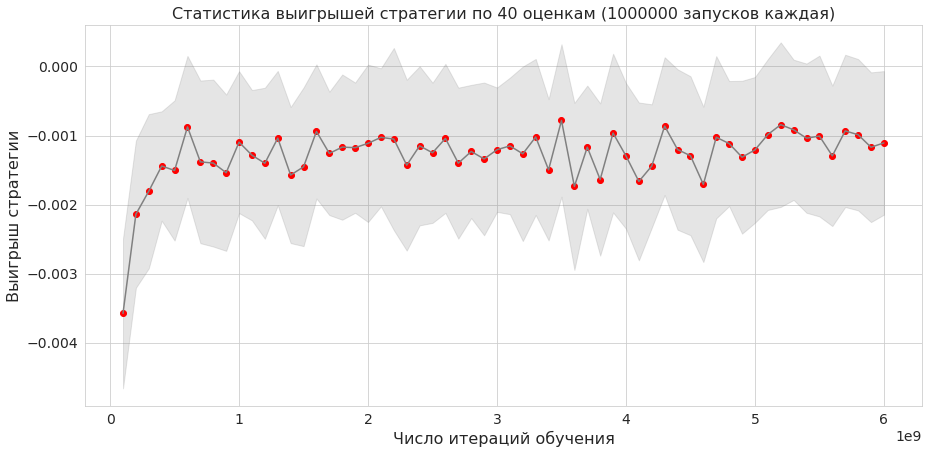

In [144]:
plot_returns(uston_qlearning_mean, uston_qlearning_std, TRAIN_ITER, EVAL_ITER, NUM_CHECKPOINTS, N_JOBS)

In [145]:
print(uston_qlearning_Q.show(20))

RunningExp(alpha=0.048187141130215064, total=7514289308, unique=67224 [top 20]
	(RekoCountState(player_sum=16, dealer_card=9, usable_ace=False, count=-39), 2)	2.000000	n=1)
	(RekoCountState(player_sum=17, dealer_card=2, usable_ace=True, count=44), 2)	2.000000	n=1)
	(RekoCountState(player_sum=10, dealer_card=6, usable_ace=False, count=46), 2)	2.000000	n=4)
	(RekoCountState(player_sum=15, dealer_card=4, usable_ace=True, count=41), 2)	2.000000	n=3)
	(RekoCountState(player_sum=6, dealer_card=6, usable_ace=False, count=44), 2)	2.000000	n=4)
	(RekoCountState(player_sum=17, dealer_card=7, usable_ace=True, count=42), 2)	2.000000	n=2)
	(RekoCountState(player_sum=9, dealer_card=4, usable_ace=False, count=45), 2)	2.000000	n=2)
	(RekoCountState(player_sum=12, dealer_card=7, usable_ace=True, count=-33), 2)	2.000000	n=1)
	(RekoCountState(player_sum=8, dealer_card=3, usable_ace=False, count=43), 2)	2.000000	n=7)
	(RekoCountState(player_sum=20, dealer_card=5, usable_ace=True, count=39), 2)	2.000000	n=

Стало немного хуже, чем с side-count.